## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'cwt-female' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
female_cwt_1e5rawcomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/benrabin/Github/hierarchical-bayesian-model-validation/results-audio/case-studies/ravdess/1e5rawcomp/cwt/female'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


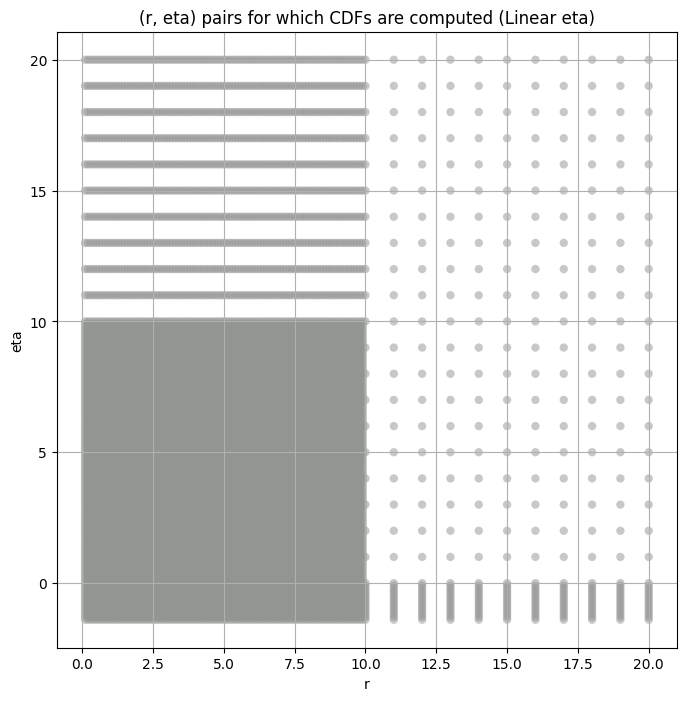

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     5.139880e+07  4.463575e+07  6.101288e+07  34.220990   15.247752   
5     2.525491e+09  2.354647e+09  2.701157e+09   5.178192    4.624777   
8     1.756310e+09  1.640077e+09  1.875928e+09   4.848721    4.287468   
11    1.467358e+09  1.381364e+09  1.555059e+09   3.327720    2.993510   
14    4.540210e+08  4.182397e+08  4.909491e+08   7.741888    6.910471   
18    8.005176e+07  7.353718e+07  8.704562e+07   8.755204    6.906692   
21    2.976653e+07  2.698129e+07  3.283116e+07  12.357149    8.886501   
24    1.521077e+07  1.316765e+07  1.748722e+07  28.562206   21.736568   
27    1.005809e+07  8.507878e+06  1.174792e+07  37.199127   31.085604   
31    2.761875e+05  2.250151e+05  3.410578e+05  63.171585   39.072056   

      kurt_upper  total_samples  
band                             
2     119.304550       100000.0  
5       5.771959       100000.0  
8       5.422123       100000.0  
11      3.676711       100000.0  
14      8.619063       100000.0  
18     11.289118       100000.0  
21     18.062698       100000.0  
24     36.871605       100000.0  
27     44.256040       100000.0  
31    149.136670       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     5.139880e+07   5.139880e+07    4.750454e+07    4.564054e+07   
5     2.525491e+09   2.525491e+09    2.487539e+09    2.454979e+09   
8     1.756310e+09   1.756310e+09    1.730308e+09    1.707048e+09   
11    1.467358e+09   1.467358e+09    1.452124e+09    1.438257e+09   
14    4.540210e+08   4.540210e+08    4.452715e+08    4.376941e+08   
18    8.005176e+07   8.005176e+07    7.756124e+07    7.580902e+07   
21    2.976653e+07   2.976653e+07    2.849705e+07    2.769029e+07   
24    1.521077e+07   1.521077e+07    1.422231e+07    1.353839e+07   
27    1.005809e+07   1.005809e+07    9.419904e+06    8.927429e+06   
31    2.761875e+05   2.761875e+05    2.471353e+05    2.304056e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       4.415126e+07     4.287191e+07     4.071407e+07     3.891142e+07   
5       2.425203e+09     2.397338e+09     2.345735e+09     2.298320e+09   
8       1.685406e+09     1.665029e+09     1.627343e+09     1.592962e+09   
11      1.425163e+09     1.412656e+09     1.389045e+09     1.366938e+09   
14      4.307489e+08     4.242638e+08     4.123437e+08     4.014900e+08   
18      7.432397e+07     7.300927e+07     7.072034e+07     6.874202e+07   
21      2.703140e+07     2.646335e+07     2.550395e+07     2.470244e+07   
24      1.297813e+07     1.249692e+07     1.169245e+07     1.103089e+07   
27      8.504144e+06     8.128584e+06     7.479391e+06     6.929288e+06   
31      2.168457e+05     2.052525e+05     1.860724e+05     1.705441e+05   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        3.734784e+07     3.595886e+07     3.470796e+07     3.156398e+07  
5        2.254159e+09     2.212617e+09     2.173246e+09     2.065585e+09  
8        1.561160e+09     1.531505e+09     1.503693e+09     1.429070e+09  
11       1.346044e+09     1.326175e+09     1.307182e+09     1.254483e+09  
14       3.914619e+08     3.821063e+08     3.733154e+08     3.496500e+08  
18       6.698146e+07     6.538684e+07     6.392452e+07     6.012584e+07  
21       2.400850e+07     2.339333e+07     2.283695e+07     2.139779e+07  
24       1.046760e+07     9.977278e+06     9.543618e+06     8.485533e+06  
27       6.452058e+06     6.031592e+06     5.657166e+06     4.739826e+06  
31       1.575202e+05     1.463543e+05     1.366393e+05     1.136431e+05

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0038869528699471134 51398796.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.00370953404673946 47504536.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.003485147925931395 45640536.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.00403663176389879 44151256.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0034933186391228575 42871908.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.004408416506182167 40714068.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.005151055836645279 38911424.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.006032030169804248 37347840.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.006691567051016145 35958864.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.00755972820919102 34707956.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.009934172189786913 31563980.0
Number of samples: 100000, Without approximation : 100000.0


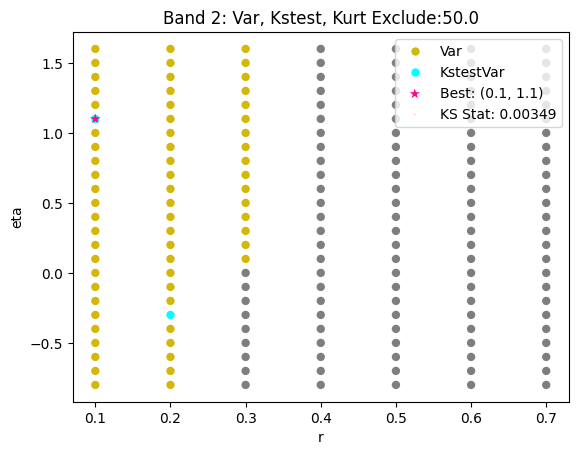

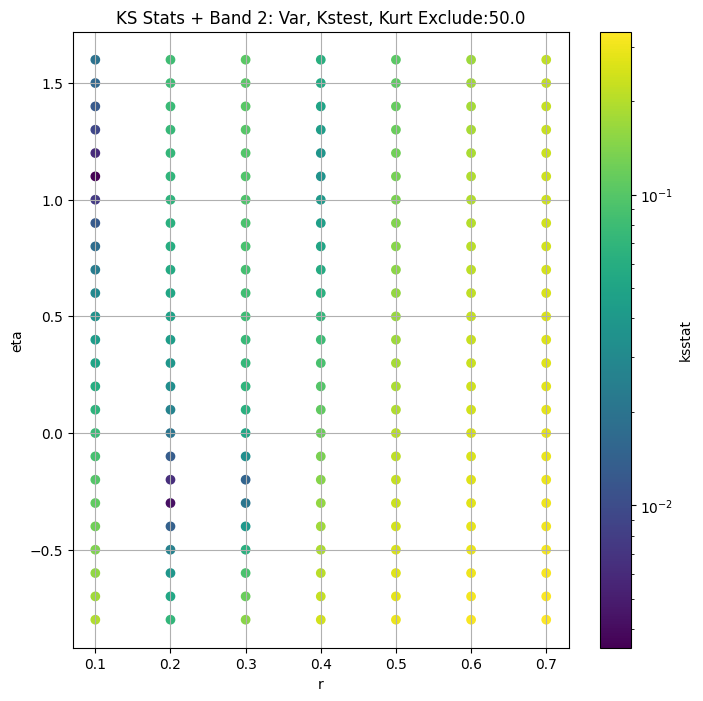

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.04279406649229783 2525491200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.04350294173299281 2487538700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.04371272549097582 2454978600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.043259156038736424 2425203500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.0428300453340425 2397337900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.043551119889789366 2345735200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.04450850530971394 2298320100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.04541486084851208 2254158600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.04487368978407191 2212617500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.04470966787666941 2173246500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.04694897580348145 2065584900.0
Number of samples: 100000, Without approximation : 100000.0


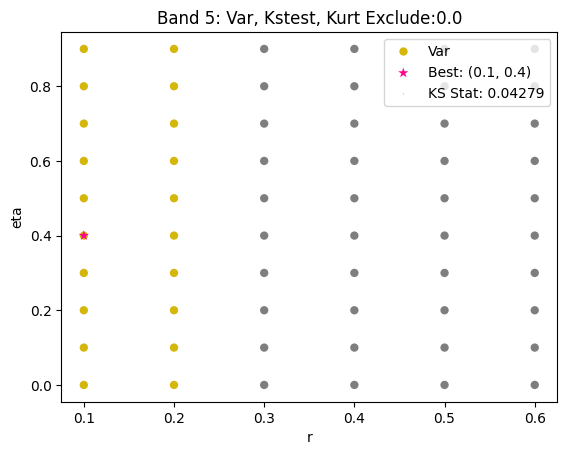

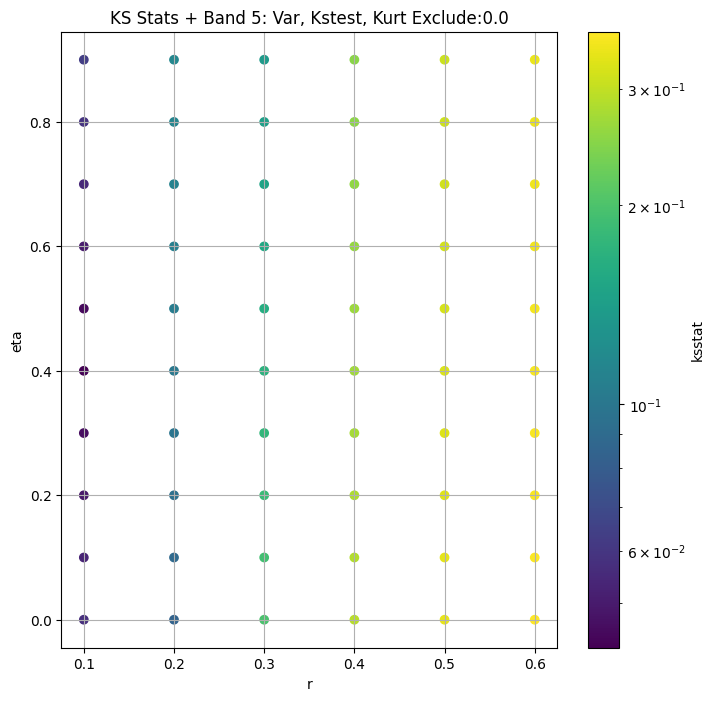

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.02422937588915558 1756310100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.023872254697033427 1730307800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.02478653675829276 1707048000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.025649651735458676 1685405800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.02625571697011403 1665028600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.025532880723911855 1627343000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.026433546778997036 1592961900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.027580322321917594 1561159700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.026962648729953798 1531505300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.02768604408296521 1503692500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.028789928369943096 1429069600.0
Number of samples: 100000, Without approximation : 100000.0


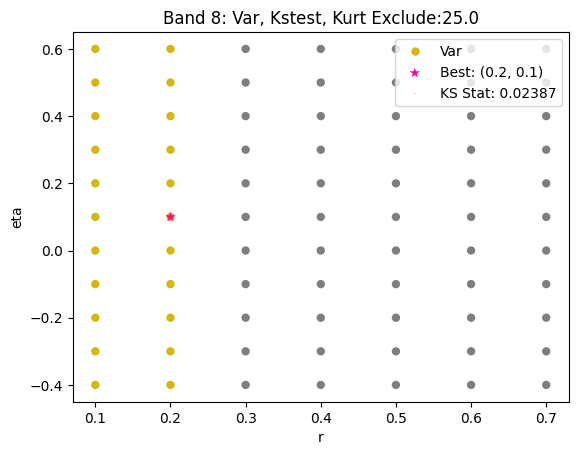

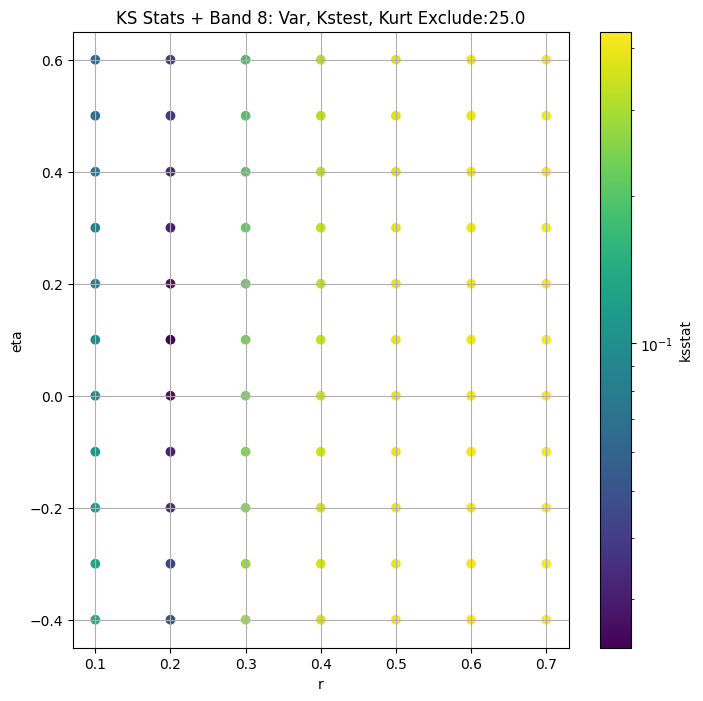

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.02635143472747073 1467357800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.026239916851682088 1452124200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.025852356206979066 1438256800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.025708008425813195 1425163100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.02625859231877603 1412656400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.027311760897820767 1389045000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.027866492761538297 1366938400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.027232121099174056 1346044400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.028059390053616948 1326175000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.02895506740312004 1307181600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.029652093643425206 1254482800.0
Number of samples: 100000, Without approximation : 100000.0


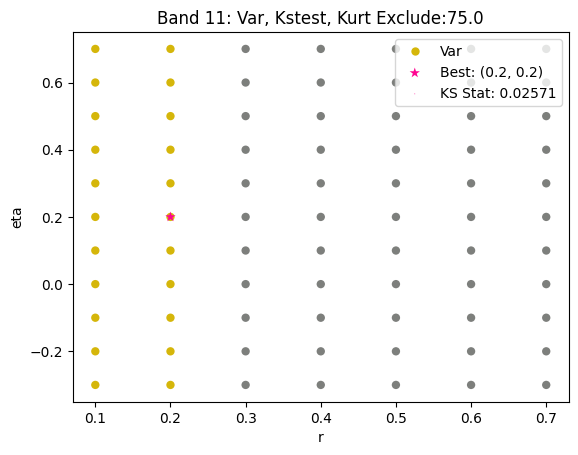

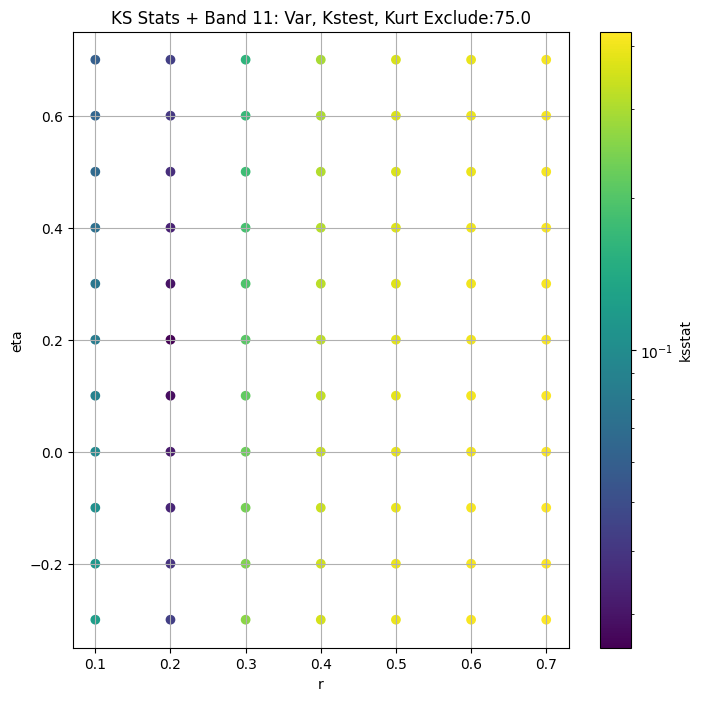

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.0189835617046933 454021000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.019478722665537018 445271520.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.018766356462563305 437694080.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.018100160293797574 430748900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.017777699788026555 424263800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.019327450995460793 412343740.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.020782676870799113 401489950.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.022170883378178324 391461860.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02159995529186781 382106340.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.020807894247582406 373315400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.02435095548884597 349650000.0
Number of samples: 100000, Without approximation : 100000.0


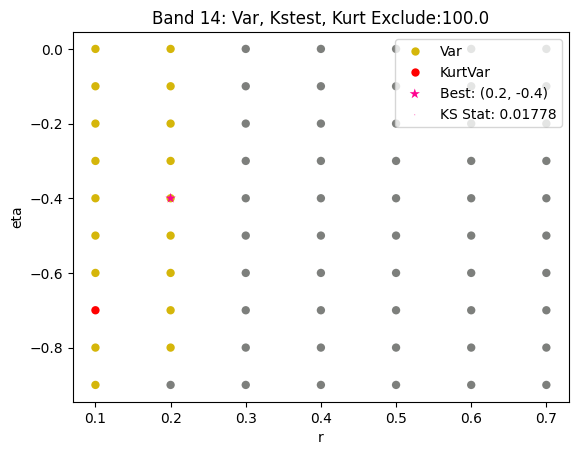

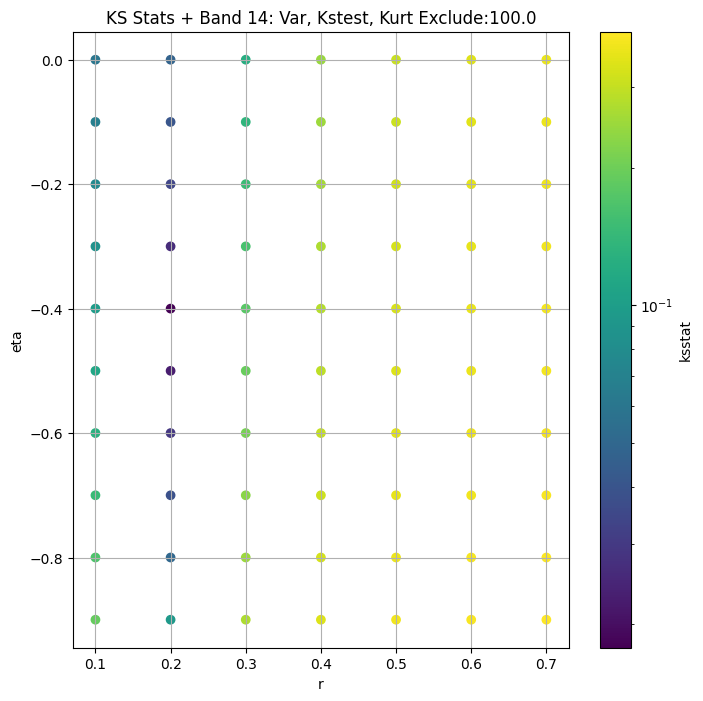

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.016853938812402824 80051760.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.017923792771752434 77561240.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.017133954064582957 75809016.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.018057123783962514 74323970.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.01905332690105821 73009270.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.01977798616421622 70720344.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.019933632600447115 68742024.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.021368425223620924 66981464.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.02157567931235399 65386836.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.0218636067649588 63924524.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.023447238367040435 60125836.0
Number of samples: 100000, Without approximation : 100000.0


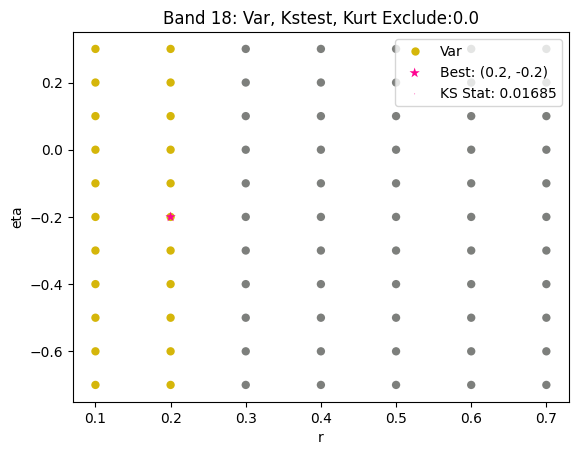

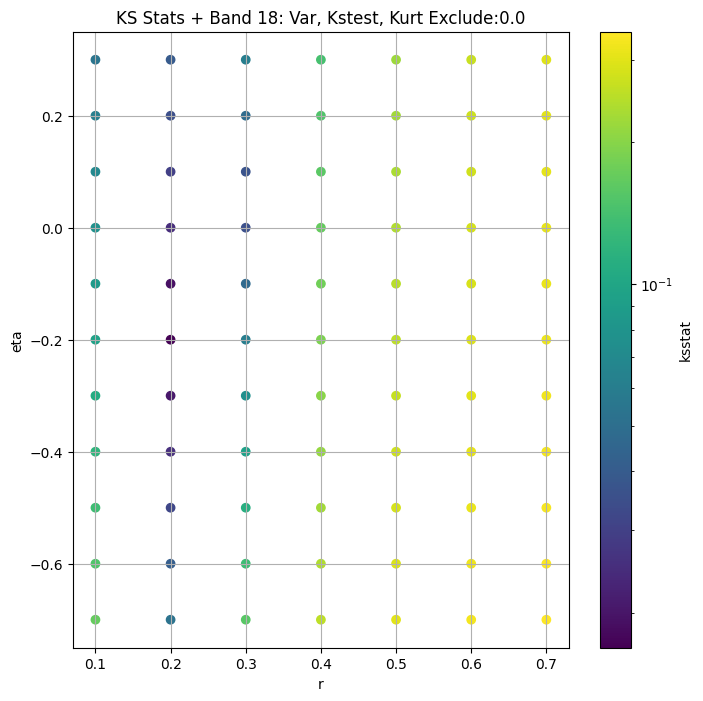

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.016256348703933443 29766528.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.01499113014812492 28497052.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.016372094395754155 27690292.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.017555538345752297 27031404.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.018603898191457025 26463352.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.01838839235808265 25503948.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.018900443781297183 24702438.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.020270755163286913 24008502.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.02154517605723849 23393332.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.021147208617521285 22836946.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.023351028131386786 21397792.0
Number of samples: 100000, Without approximation : 100000.0


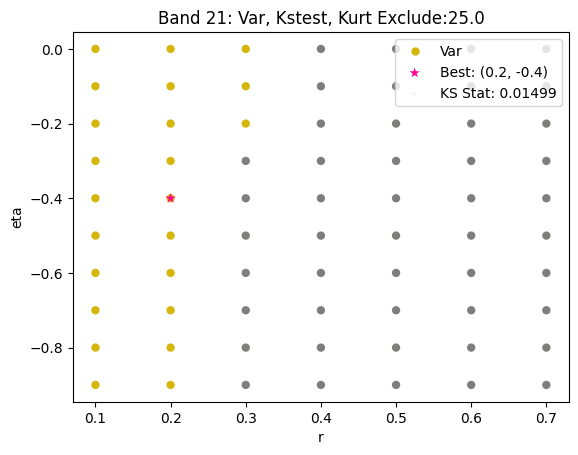

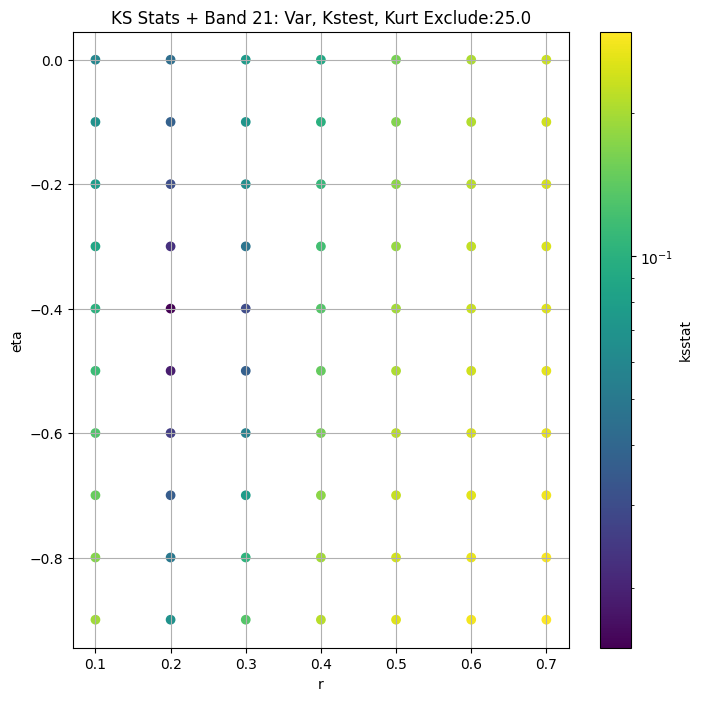

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.007207154931336376 15210772.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.009897442206039844 14222307.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.012069233705259669 13538388.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.014019249368246278 12978129.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.015813831329173245 12496919.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.013009881063585249 11692453.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.013340539687844988 11030889.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.015341057857602286 10467601.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.01726908250740379 9977278.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.01912645729786394 9543618.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.018805650505977357 8485533.0
Number of samples: 100000, Without approximation : 100000.0


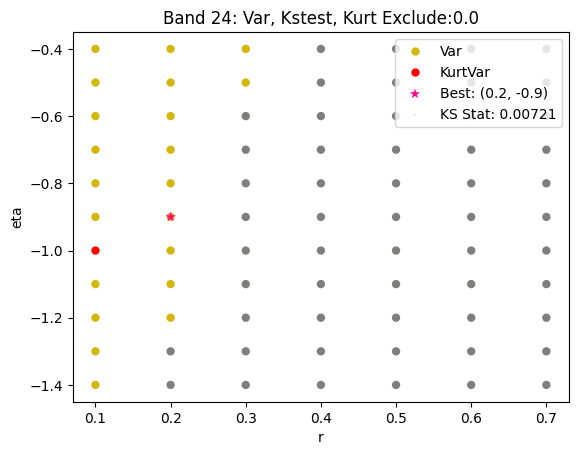

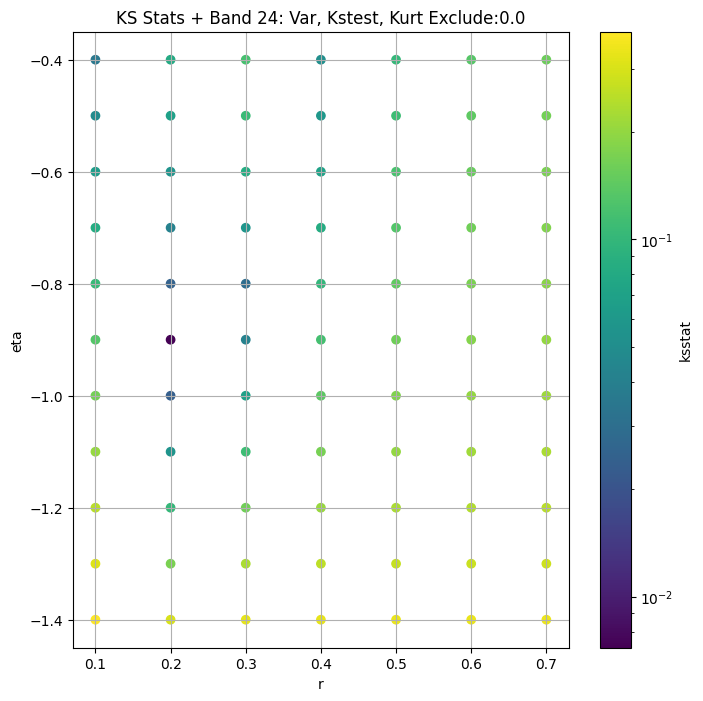

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.011814228285230044 10058090.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.011808424750714752 9419904.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.011669702249886837 8927429.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.013782644670556787 8504144.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.013612914180125224 8128583.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.013296907925278822 7479391.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.013029463886771508 6929288.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.01246131253251756 6452057.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.010593219153167799 6031592.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.010451450773603987 5657166.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.011321569094284833 4739825.5
Number of samples: 100000, Without approximation : 100000.0


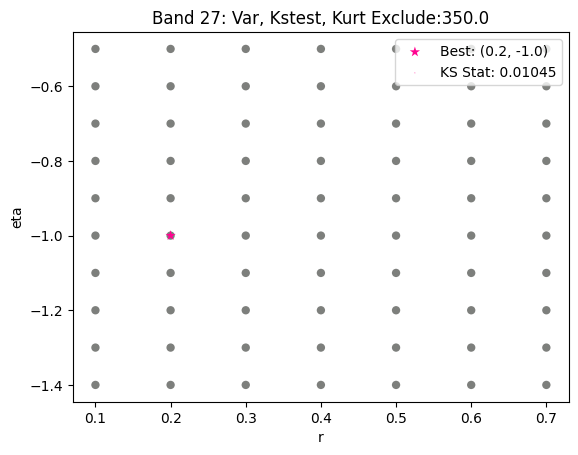

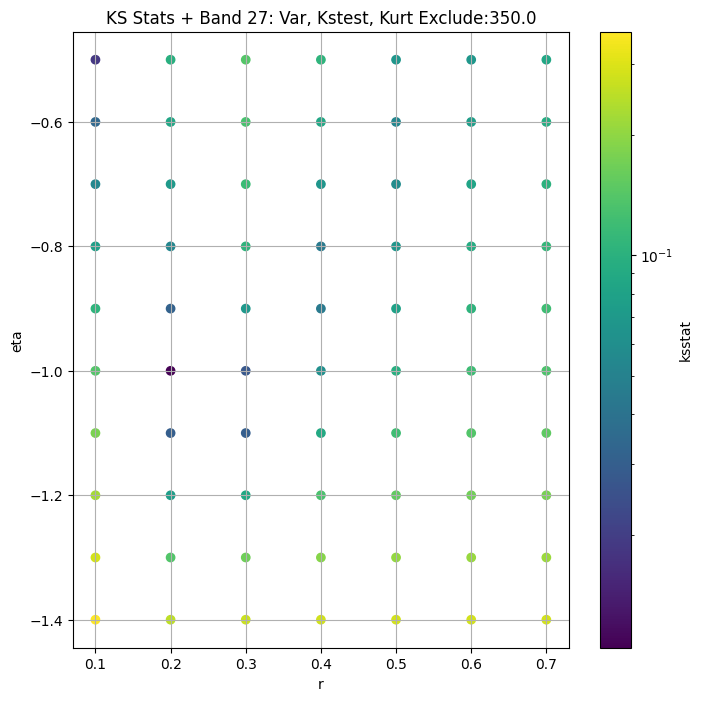

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.03238994207967966 276187.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.032164680926350386 247135.31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.03201914363085151 230405.61


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.03189137649300183 216845.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.031774457504067266 205252.53


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.031562445969838204 186072.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.03195196771171227 170544.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.031755835789725795 157520.16


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.03156768390498382 146354.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.03138719726683531 136639.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.030874719150584207 113643.08
Number of samples: 100000, Without approximation : 100000.0


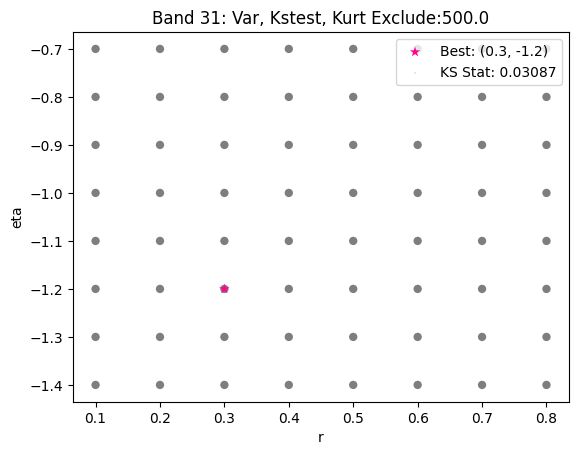

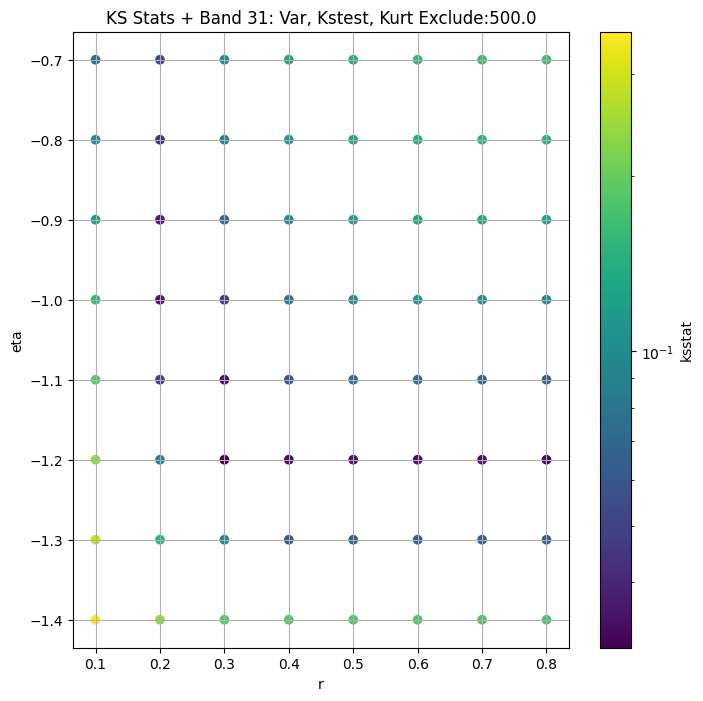

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     5.139880e+07  4.463575e+07  6.101288e+07  34.220990   15.247752   
5     2.525491e+09  2.354647e+09  2.701157e+09   5.178192    4.624777   
8     1.756310e+09  1.640077e+09  1.875928e+09   4.848721    4.287468   
11    1.467358e+09  1.381364e+09  1.555059e+09   3.327720    2.993510   
14    4.540210e+08  4.182397e+08  4.909491e+08   7.741888    6.910471   
18    8.005176e+07  7.353718e+07  8.704562e+07   8.755204    6.906692   
21    2.976653e+07  2.698129e+07  3.283116e+07  12.357149    8.886501   
24    1.521077e+07  1.316765e+07  1.748722e+07  28.562206   21.736568   
27    1.005809e+07  8.507878e+06  1.174792e+07  37.199127   31.085604   
31    2.761875e+05  2.250151e+05  3.410578e+05  63.171585   39.072056   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2     119.304550       100000.0             0.003485        0.1          1.1   
5       5.771959       100000.0             0.042794        0.1          0.4   
8       5.422123       100000.0             0.023872        0.2          0.1   
11      3.676711       100000.0             0.025708        0.2          0.2   
14      8.619063       100000.0             0.017778        0.2         -0.4   
18     11.289118       100000.0             0.016854        0.2         -0.2   
21     18.062698       100000.0             0.014991        0.2         -0.4   
24     36.871605       100000.0             0.007207        0.2         -0.9   
27     44.256040       100000.0             0.010451        0.2         -1.0   
31    149.136670       100000.0             0.030875        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      6.851155e-08                    50.0        4.564054e+07   
5      5.303298e-05                     0.0        2.525491e+09   
8      1.820610e+04                    25.0        1.730308e+09   
11     1.169297e+04                    75.0        1.425163e+09   
14     1.959549e+04                   100.0        4.242638e+08   
18     1.936709e+03                     0.0        8.005176e+07   
21     1.316195e+03                    25.0        2.849705e+07   
24     6.036021e+03                     0.0        1.521077e+07   
27     4.018855e+03                   350.0        5.657166e+06   
31     1.227177e+04                   500.0        1.136431e+05   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
5                    0.004293  
8                    0.004293  
11                   0.004293  
14                   0.004293  
18                   0.004293  
21                   0.004293  
24                   0.004293  
27                   0.004293  
31                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 100 = 150, ksstat: 0.005302016384894723, var: 40714068.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 75 = 125, ksstat: 0.004926195305099308, var: 41737872.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 50 = 100, ksstat: 0.0043705156964450875, var: 42871908.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 25 = 75, ksstat: 0.003736966376088998, var: 44151256.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + 0 = 50, ksstat: 0.003485147925931395, var: 45640536.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + -25 = 25, ksstat: 0.00275583599877105, var: 47504536.0


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 2, 50.0 + -50 = 0, ksstat: 0.0019504343990337514, var: 51398796.0
Number of samples: 100000, Without approximation : 100000.0


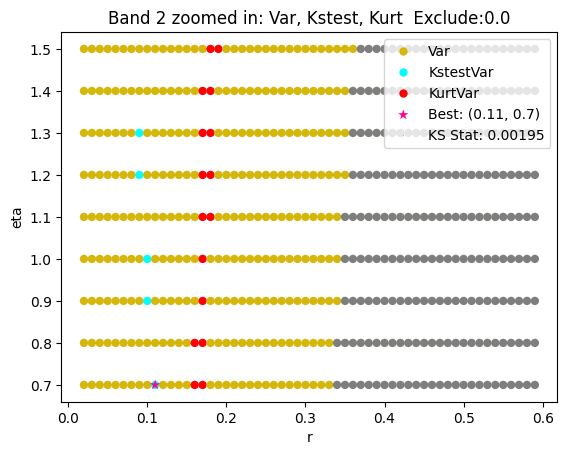

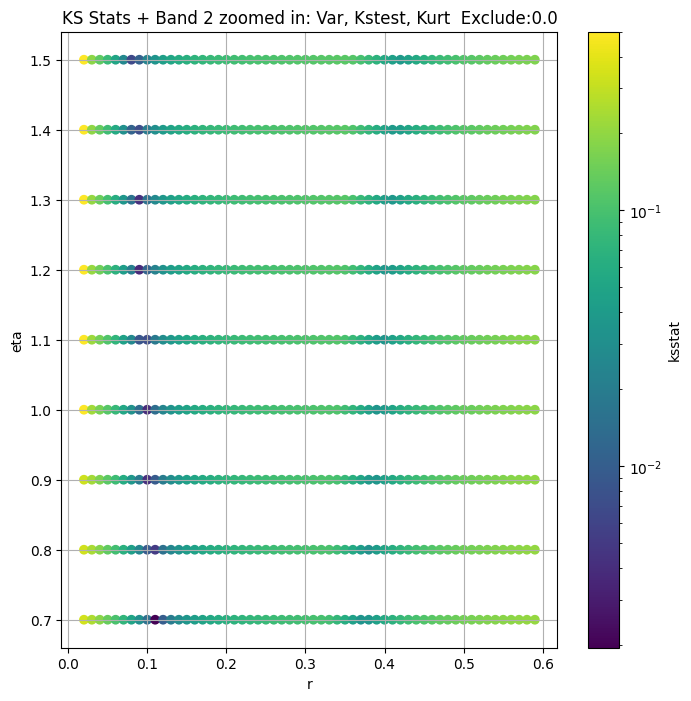

Band 5


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 100 = 100, ksstat: 0.04153686139577606, var: 2397337856.0


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 75 = 75, ksstat: 0.041918895991139446, var: 2425203456.0


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 50 = 50, ksstat: 0.0413483418942453, var: 2454978560.0


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 25 = 25, ksstat: 0.04088274223860039, var: 2487538688.0


  0%|          | 0/567 [00:00<?, ?it/s]

Finding Minimum after computing 567 CDFs
band 5, 0.0 + 0 = 0, ksstat: 0.04144593297089283, var: 2525491200.0
Number of samples: 100000, Without approximation : 100000.0


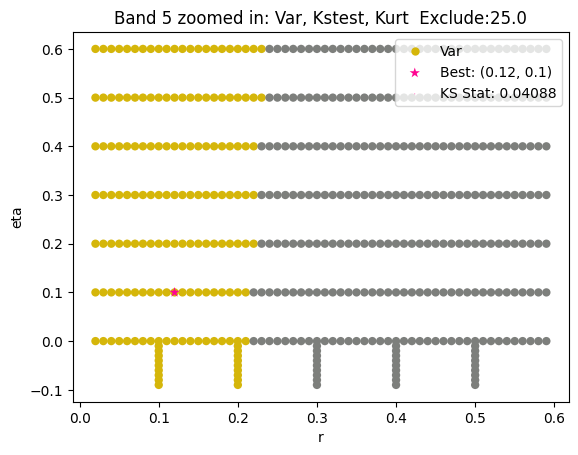

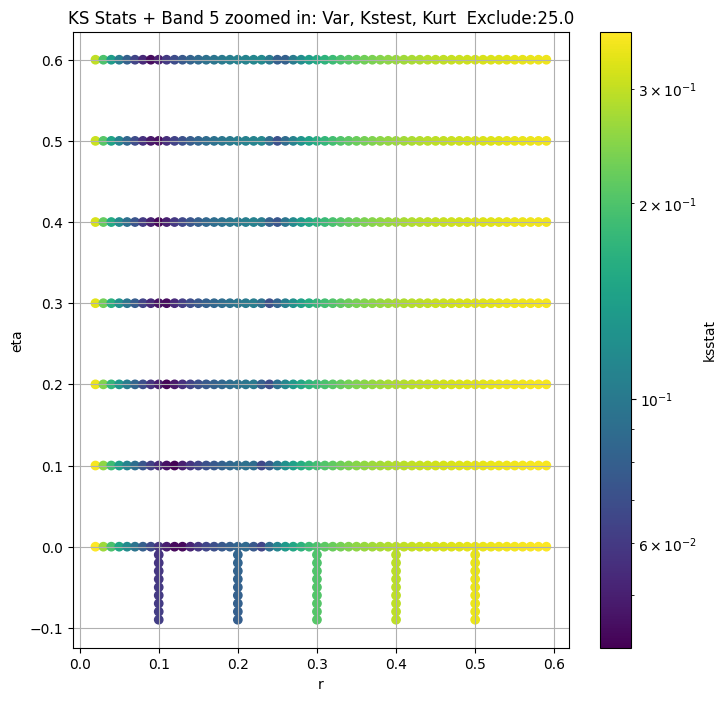

Band 8


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 25.0 + 100 = 125, ksstat: 0.024736435883926697, var: 1645721728.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 25.0 + 75 = 100, ksstat: 0.024277930658142488, var: 1665028608.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 25.0 + 50 = 75, ksstat: 0.024409927635976436, var: 1685405824.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 25.0 + 25 = 50, ksstat: 0.024409927635976436, var: 1707047936.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 25.0 + 0 = 25, ksstat: 0.023872254697033427, var: 1730307840.0


  0%|          | 0/873 [00:00<?, ?it/s]

Finding Minimum after computing 873 CDFs
band 8, 25.0 + -25 = 0, ksstat: 0.023171600844973494, var: 1756310144.0
Number of samples: 100000, Without approximation : 100000.0


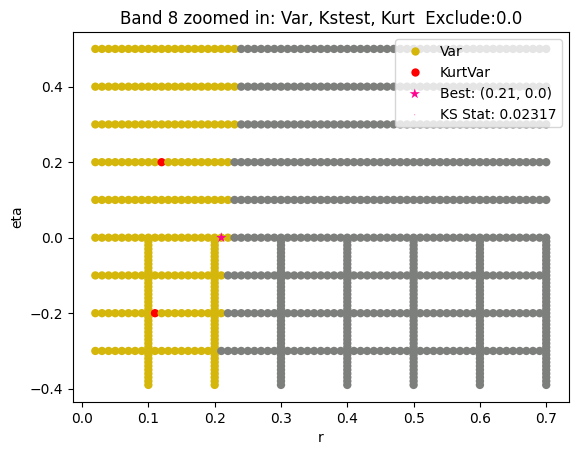

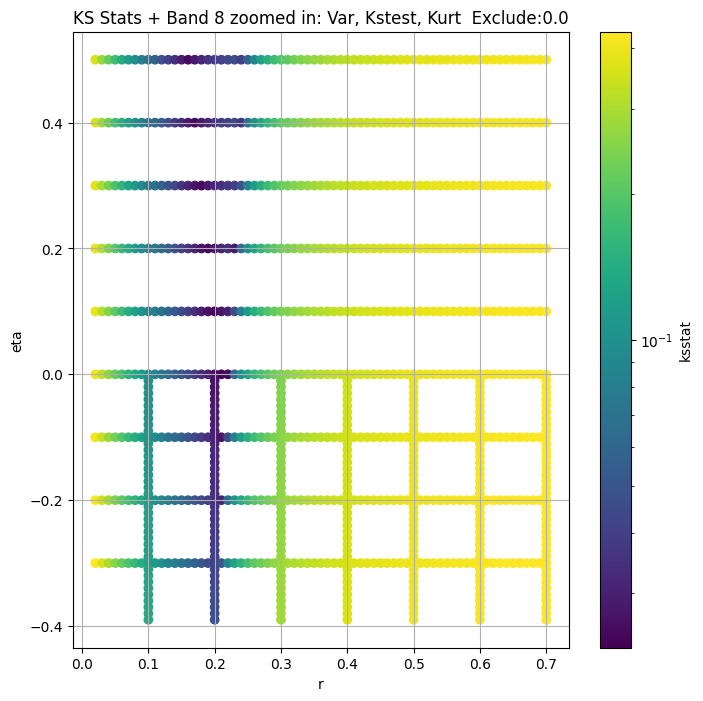

Band 11


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 75.0 + 100 = 175, ksstat: 0.026516865000404344, var: 1377825152.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 75.0 + 75 = 150, ksstat: 0.026851711033967385, var: 1389044992.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 75.0 + 50 = 125, ksstat: 0.02679263765698628, var: 1400639744.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 75.0 + 25 = 100, ksstat: 0.02625859231877603, var: 1412656384.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 75.0 + 0 = 75, ksstat: 0.025708008425813195, var: 1425163136.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 75.0 + -25 = 50, ksstat: 0.025167927842654897, var: 1438256768.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 75.0 + -50 = 25, ksstat: 0.024850452895403302, var: 1452124160.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 11, 75.0 + -75 = 0, ksstat: 0.024383601444752767, var: 1467357824.0
Number of samples: 100000, Without approximation : 100000.0


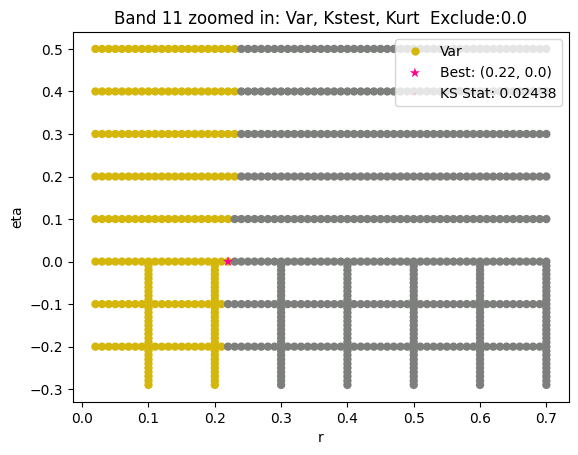

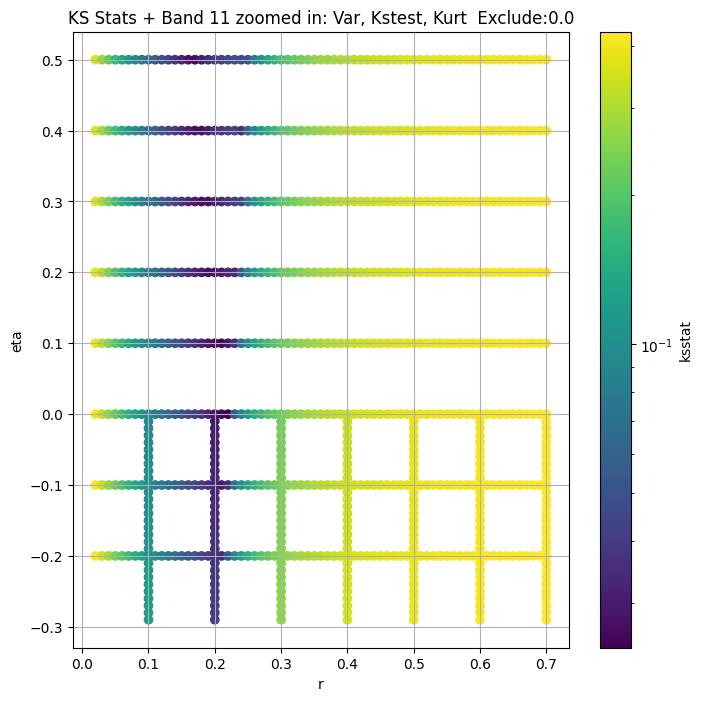

Band 14


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + 100 = 200, ksstat: 0.019110868765528602, var: 401489952.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + 75 = 175, ksstat: 0.018798515268074273, var: 406802112.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + 50 = 150, ksstat: 0.018475260741566857, var: 412343744.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + 25 = 125, ksstat: 0.018137047406567283, var: 418148864.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + 0 = 100, ksstat: 0.017777699788026555, var: 424263808.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + -25 = 75, ksstat: 0.017391449286785182, var: 430748896.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + -50 = 50, ksstat: 0.016969115056968145, var: 437694080.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + -75 = 25, ksstat: 0.016694581908649142, var: 445271520.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 14, 100.0 + -100 = 0, ksstat: 0.015659071321834903, var: 454020992.0
Number of samples: 100000, Without approximation : 100000.0


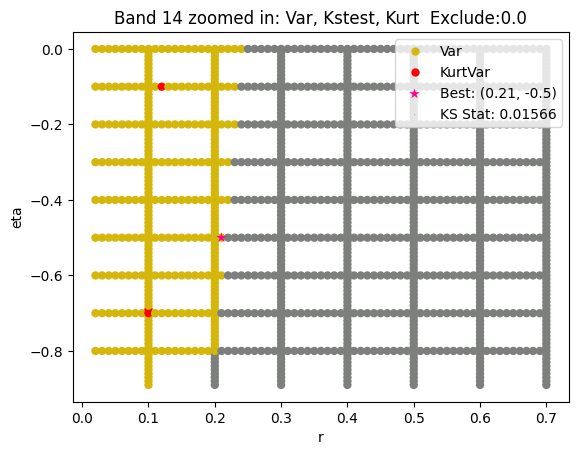

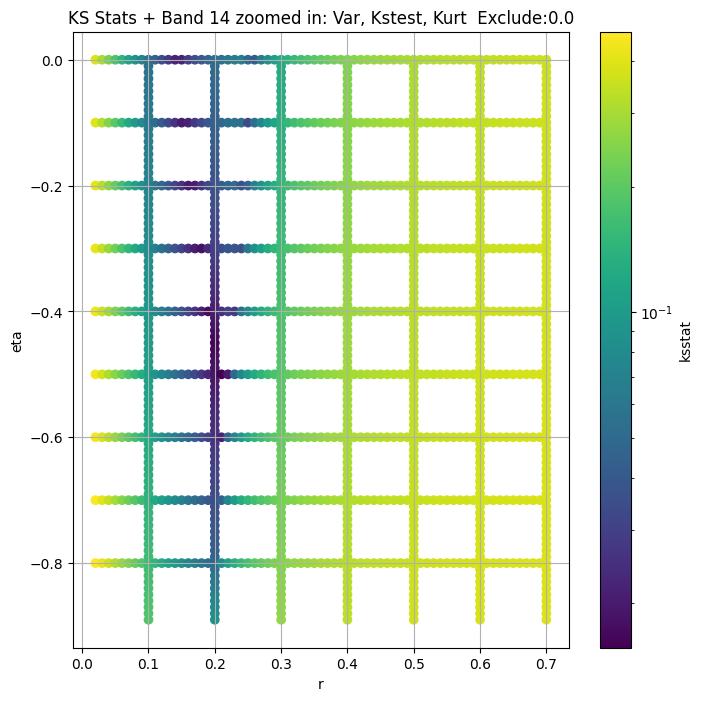

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.016553399196107654, var: 73009272.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.01642602691357431, var: 74323968.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.015338800458467916, var: 75809016.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.01593496131435468, var: 77561240.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.014212552252416244, var: 80051760.0
Number of samples: 100000, Without approximation : 100000.0


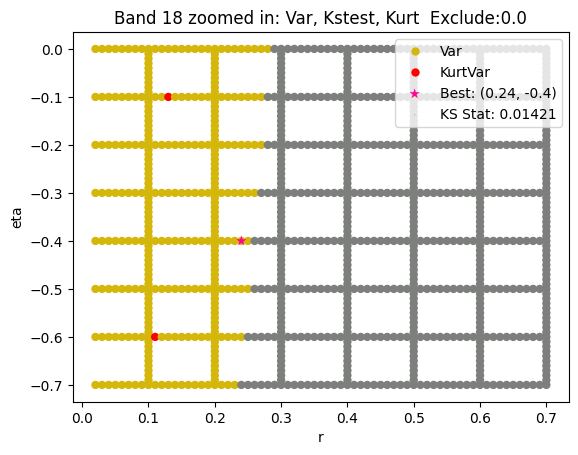

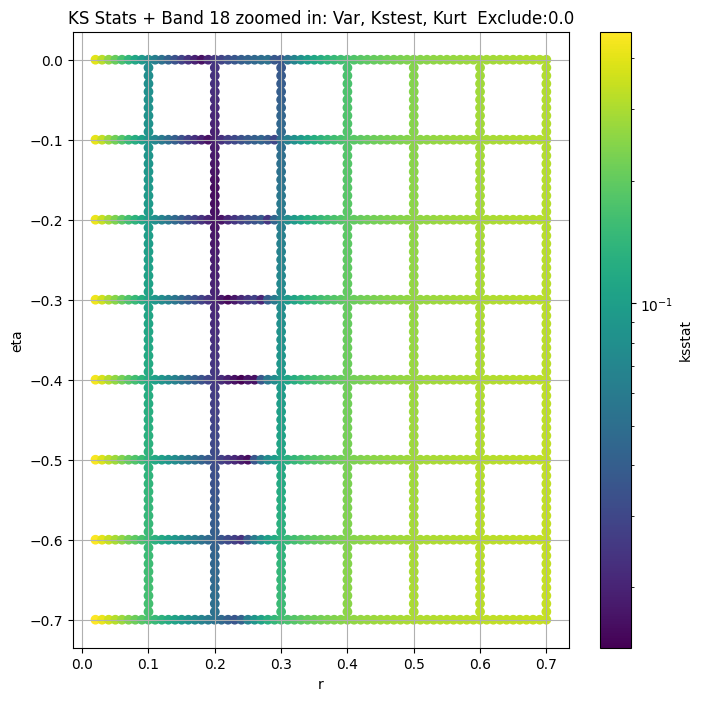

Band 21


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 100 = 125, ksstat: 0.016065527191040596, var: 25959348.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 75 = 100, ksstat: 0.01523260983906849, var: 26463352.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 50 = 75, ksstat: 0.014236317385790231, var: 27031404.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 25 = 50, ksstat: 0.014838099694289952, var: 27690292.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + 0 = 25, ksstat: 0.013470995386369089, var: 28497052.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 21, 25.0 + -25 = 0, ksstat: 0.012885280002248534, var: 29766528.0
Number of samples: 100000, Without approximation : 100000.0


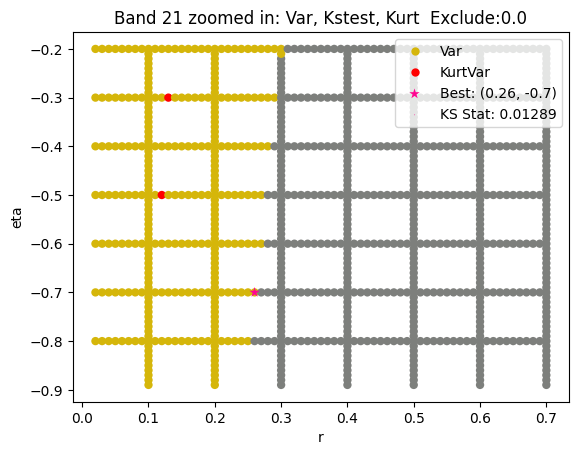

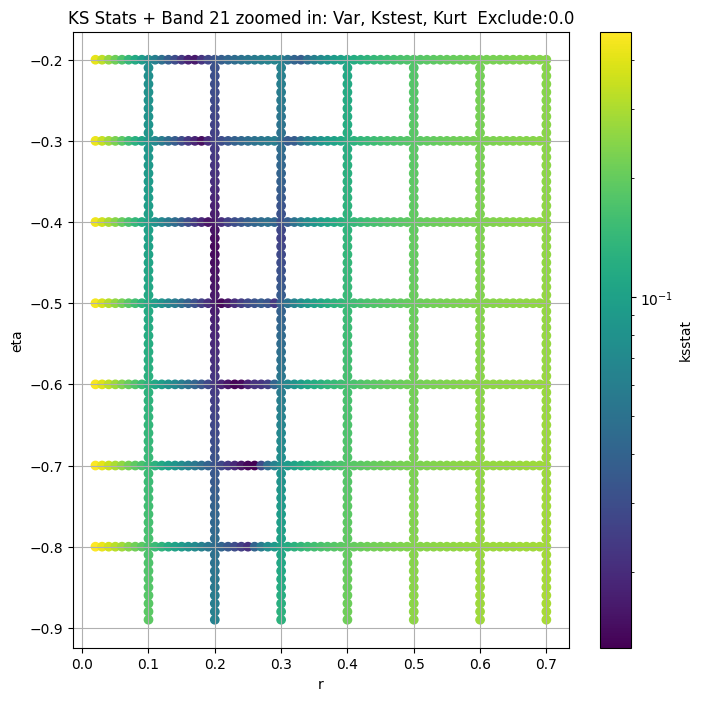

Band 24


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 100 = 100, ksstat: 0.009344346809747828, var: 12496919.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 75 = 75, ksstat: 0.009707769799884858, var: 12978129.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 50 = 50, ksstat: 0.008158586744097807, var: 13538388.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 25 = 25, ksstat: 0.0064443400610415535, var: 14222307.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 0.0 + 0 = 0, ksstat: 0.005214694582408752, var: 15210772.0
Number of samples: 100000, Without approximation : 100000.0


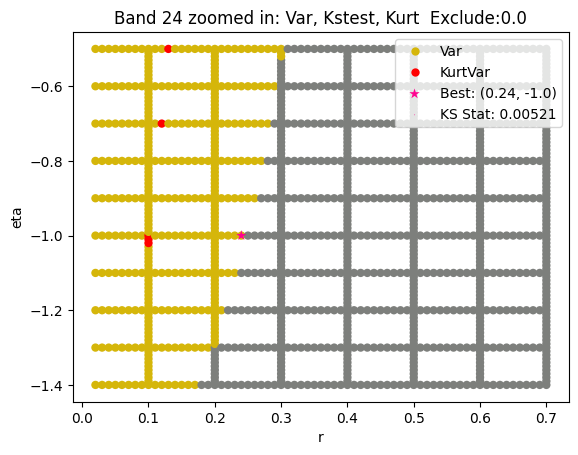

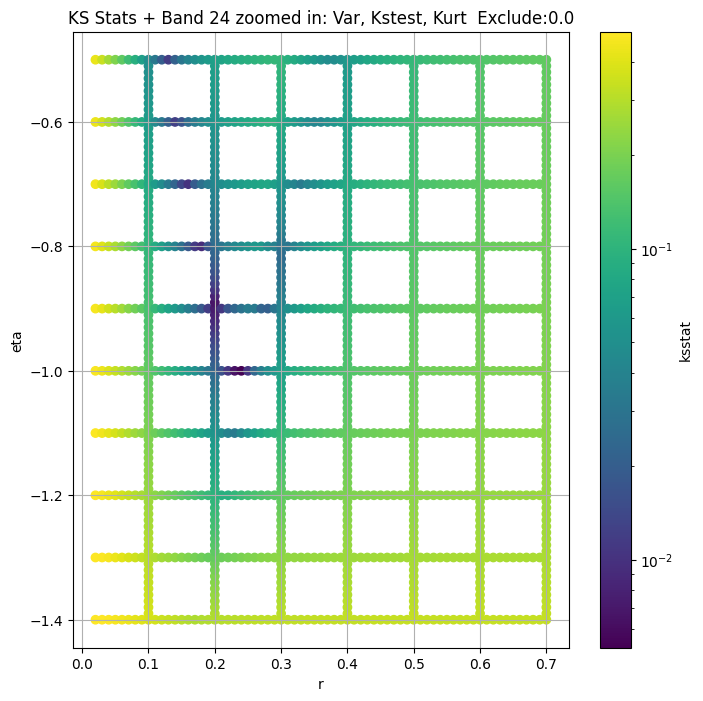

Band 27


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 100 = 450, ksstat: 0.00947018264920588, var: 5016515.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 75 = 425, ksstat: 0.00912088124501895, var: 5164921.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 50 = 400, ksstat: 0.009036079560764576, var: 5320754.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 25 = 375, ksstat: 0.008723181046189797, var: 5484614.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 0 = 350, ksstat: 0.008548711513012397, var: 5657166.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -25 = 325, ksstat: 0.008647010636928187, var: 5839176.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -50 = 300, ksstat: 0.008362314774912338, var: 6031592.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -75 = 275, ksstat: 0.008393325398540985, var: 6235507.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -100 = 250, ksstat: 0.008427362625283652, var: 6452057.5
Number of samples: 100000, Without approximation : 100000.0


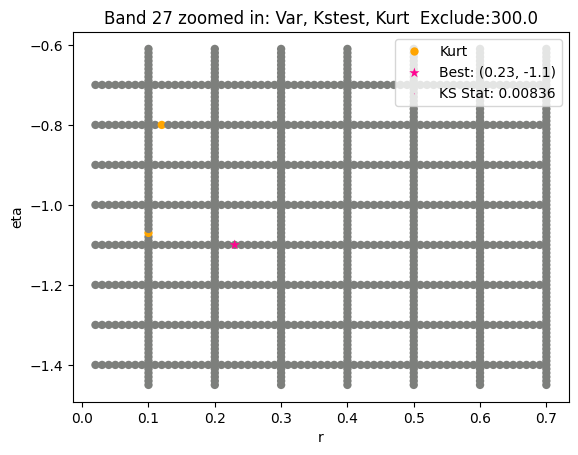

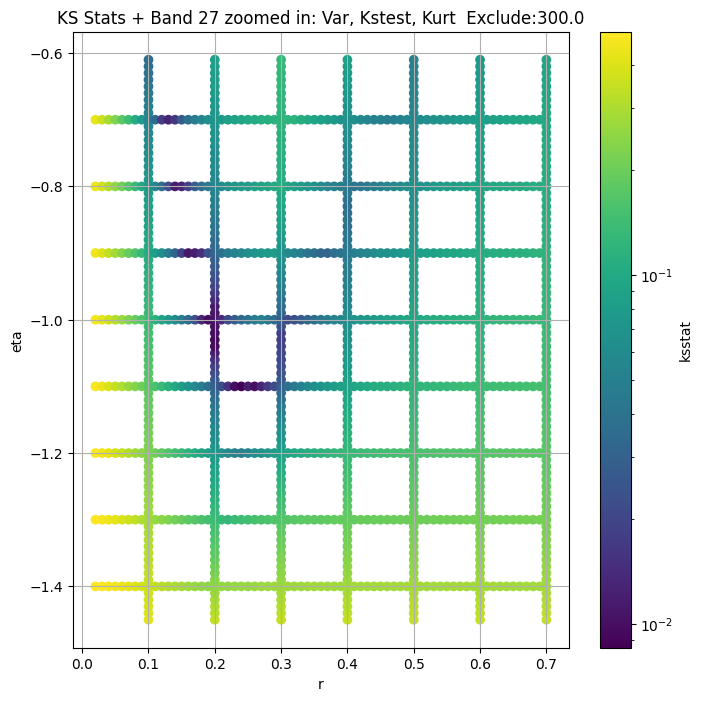

Band 31


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 100 = 600, ksstat: 0.02610859280145228, var: 101887.9765625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 75 = 575, ksstat: 0.02610859280145228, var: 104618.8203125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 50 = 550, ksstat: 0.02610859280145228, var: 107480.9375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 25 = 525, ksstat: 0.02610859280145228, var: 110485.2421875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + 0 = 500, ksstat: 0.025681665190444014, var: 113643.078125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -25 = 475, ksstat: 0.025473839709797608, var: 116966.5


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -50 = 450, ksstat: 0.02555682482389443, var: 120469.6015625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -75 = 425, ksstat: 0.025641181076962838, var: 124168.390625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 500.0 + -100 = 400, ksstat: 0.025726989393452526, var: 128081.53125
Number of samples: 100000, Without approximation : 100000.0


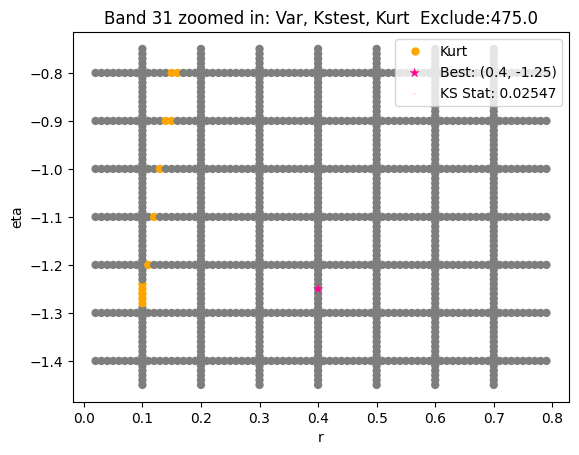

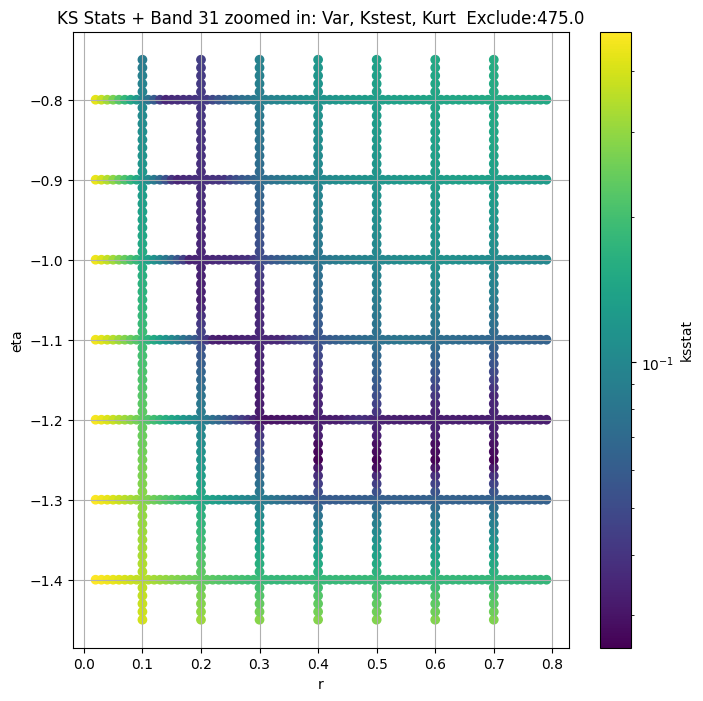

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     5.139880e+07  4.463575e+07  6.101288e+07  34.220990   15.247752   
5     2.525491e+09  2.354647e+09  2.701157e+09   5.178192    4.624777   
8     1.756310e+09  1.640077e+09  1.875928e+09   4.848721    4.287468   
11    1.467358e+09  1.381364e+09  1.555059e+09   3.327720    2.993510   
14    4.540210e+08  4.182397e+08  4.909491e+08   7.741888    6.910471   
18    8.005176e+07  7.353718e+07  8.704562e+07   8.755204    6.906692   
21    2.976653e+07  2.698129e+07  3.283116e+07  12.357149    8.886501   
24    1.521077e+07  1.316765e+07  1.748722e+07  28.562206   21.736568   
27    1.005809e+07  8.507878e+06  1.174792e+07  37.199127   31.085604   
31    2.761875e+05  2.250151e+05  3.410578e+05  63.171585   39.072056   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2     119.304550       100000.0             0.003485        0.1          1.1   
5       5.771959       100000.0             0.042794        0.1          0.4   
8       5.422123       100000.0             0.023872        0.2          0.1   
11      3.676711       100000.0             0.025708        0.2          0.2   
14      8.619063       100000.0             0.017778        0.2         -0.4   
18     11.289118       100000.0             0.016854        0.2         -0.2   
21     18.062698       100000.0             0.014991        0.2         -0.4   
24     36.871605       100000.0             0.007207        0.2         -0.9   
27     44.256040       100000.0             0.010451        0.2         -1.0   
31    149.136670       100000.0             0.030875        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      6.851155e-08                    50.0        5.139880e+07   
5      5.303298e-05                     0.0        2.487539e+09   
8      1.820610e+04                    25.0        1.756310e+09   
11     1.169297e+04                    75.0        1.467358e+09   
14     1.959549e+04                   100.0        4.540210e+08   
18     1.936709e+03                     0.0        8.005176e+07   
21     1.316195e+03                    25.0        2.976653e+07   
24     6.036021e+03                     0.0        1.521077e+07   
27     4.018855e+03                   350.0        6.031592e+06   
31     1.227177e+04                   500.0        1.169665e+05   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.001950    0.11      0.70   
5                    0.004293          0.040883    0.12      0.10   
8                    0.004293          0.023172    0.21      0.00   
11                   0.004293          0.024384    0.22      0.00   
14                   0.004293          0.015659    0.21     -0.50   
18                   0.004293          0.014213    0.24     -0.40   
21                   0.004293          0.012885    0.26     -0.70   
24                   0.004293          0.005215    0.24     -1.00   
27                   0.004293          0.008362    0.23     -1.10   
31                   0.004293          0.025474    0.40     -1.25   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2          0.000015                  0.0       506250  
5          0.150793                 25.0         1107  
8      52300.417906                  0.0         3514  
11     87747.619175                  0.0         3125  
14     60949.594133                  0.0         7908  
18     44150.799310                  0.0         9375  
21    100000.000000                  0.0        10546  
24     85420.705291                

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

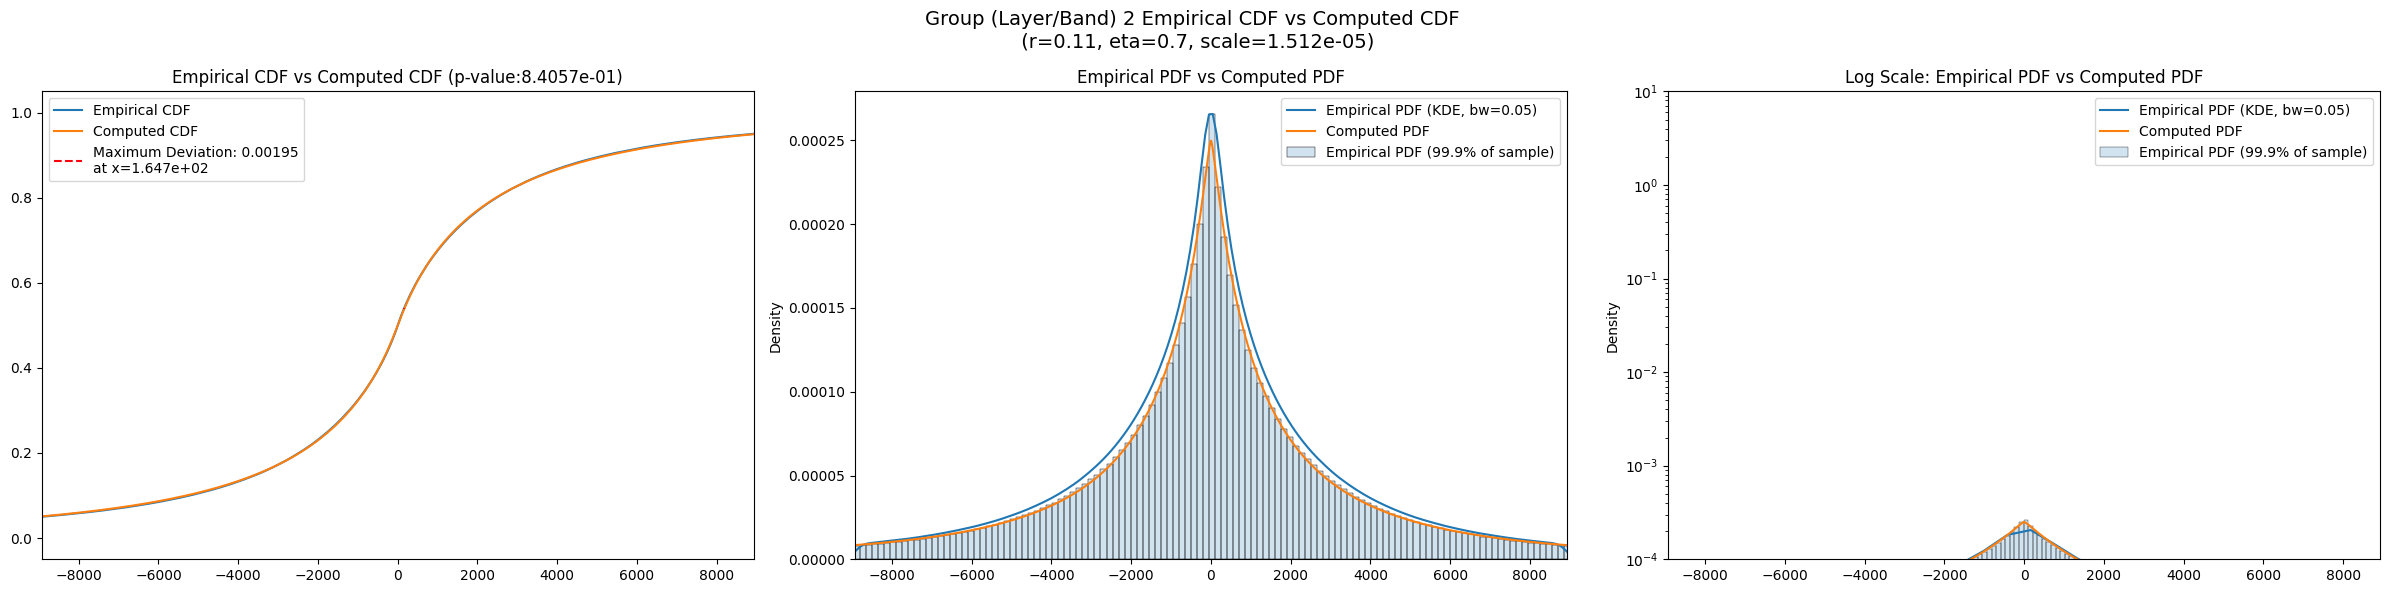

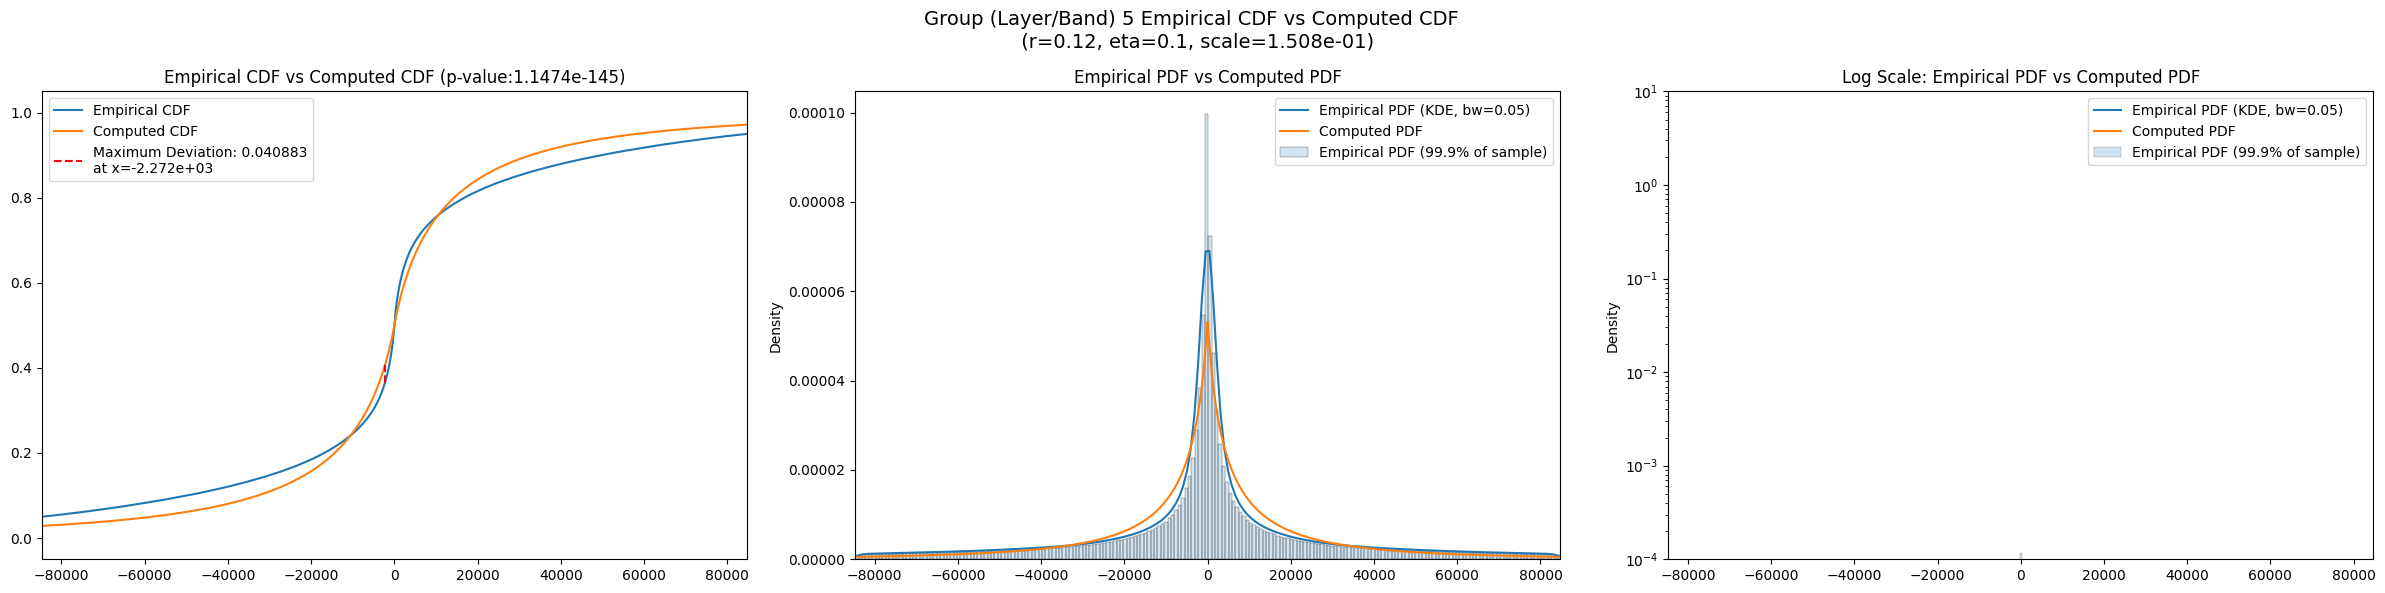

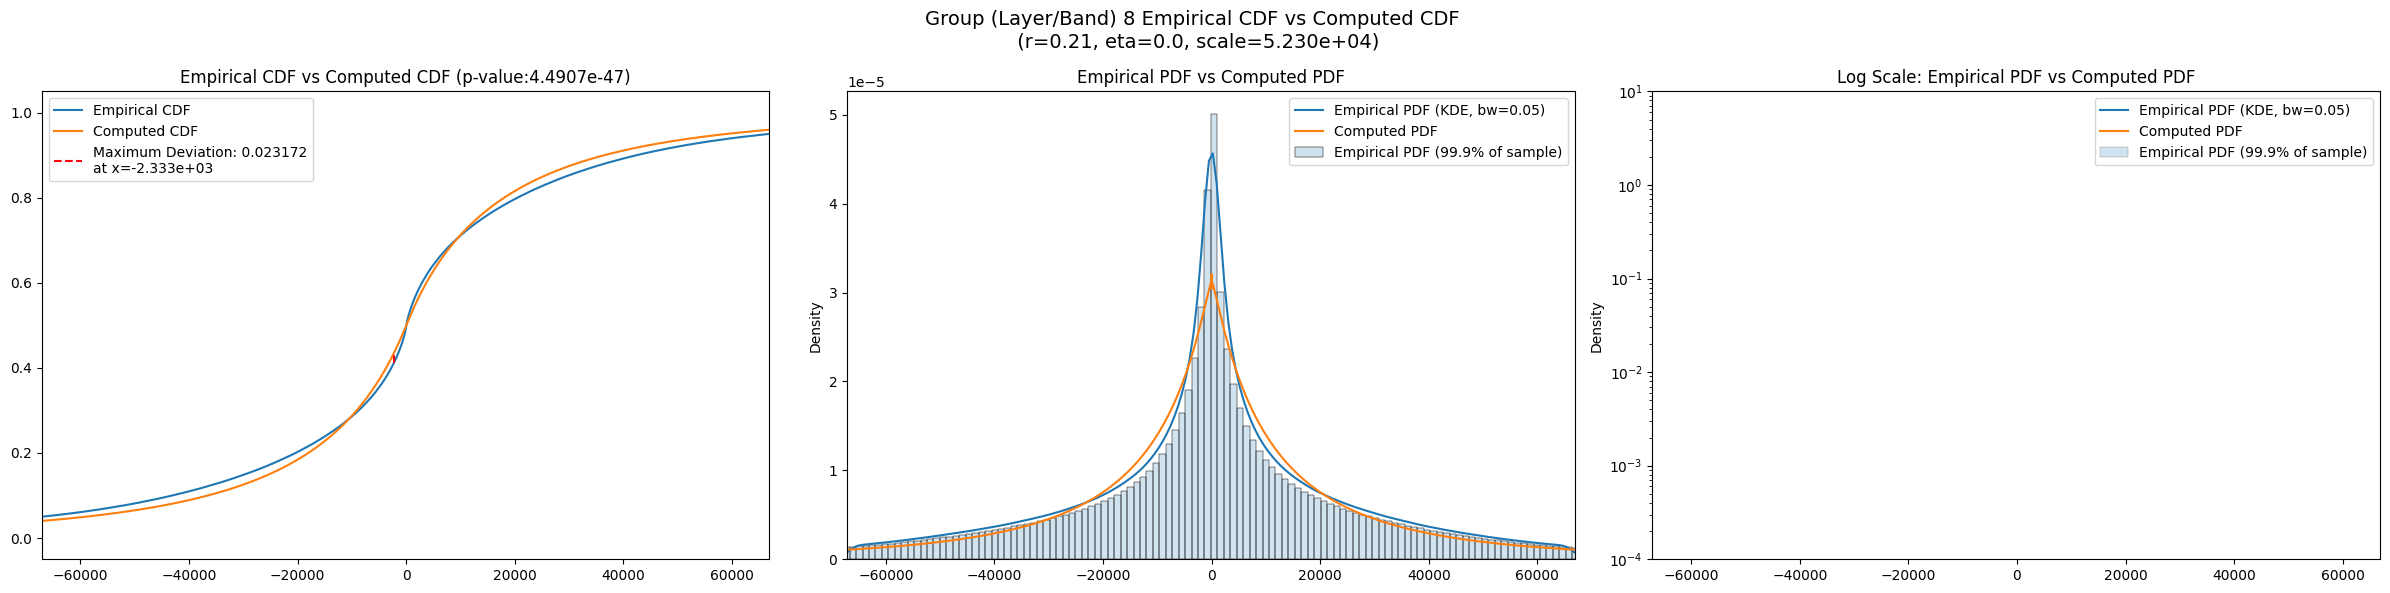

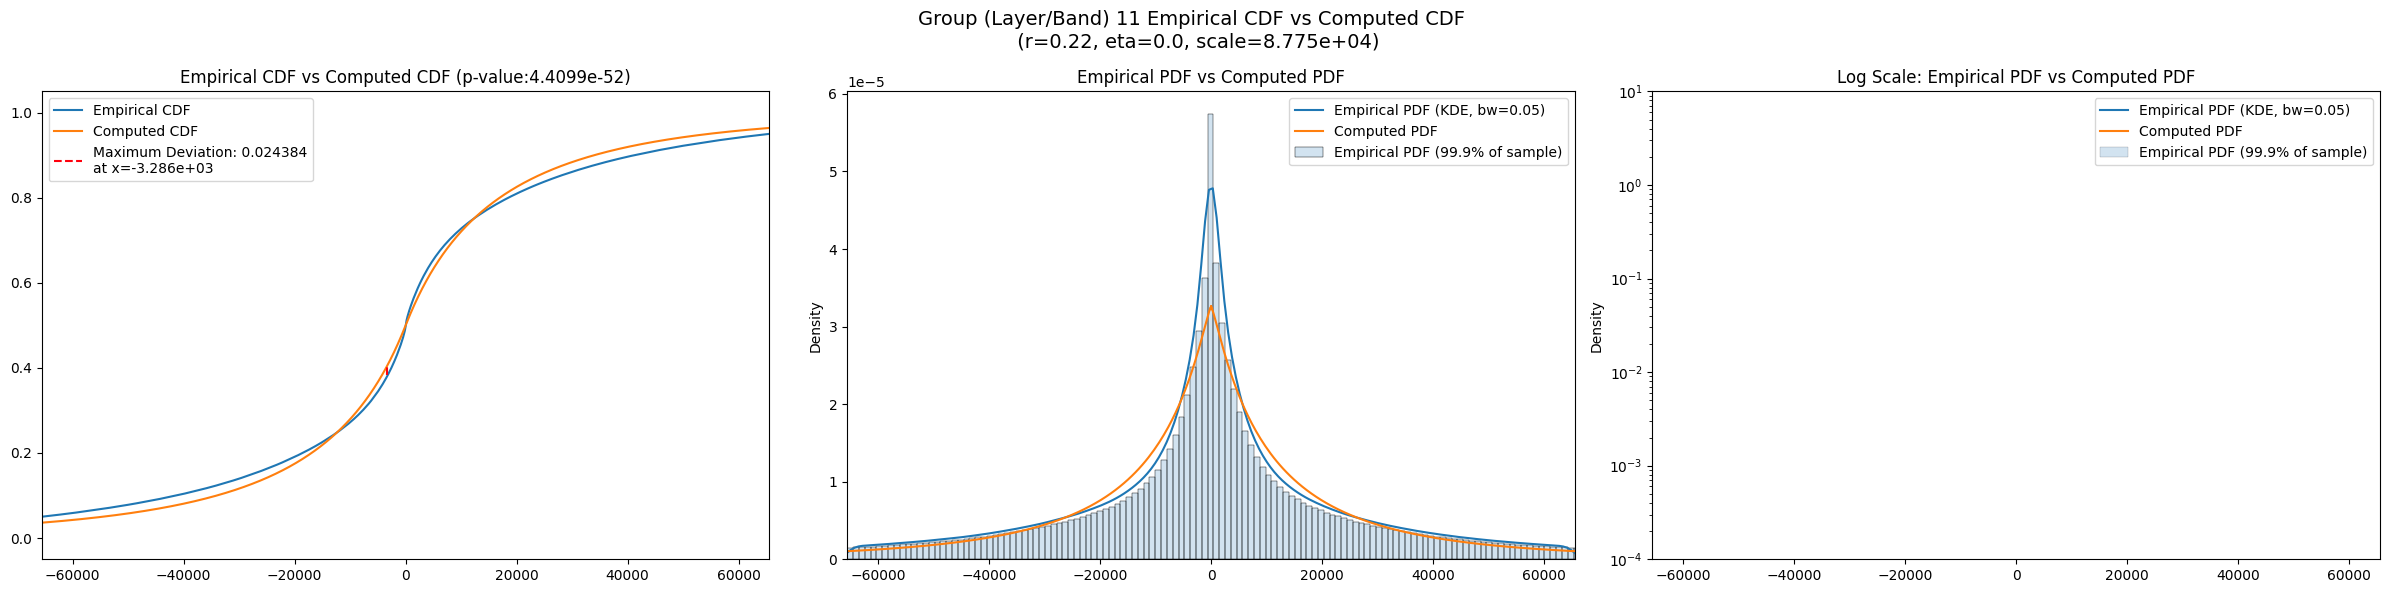

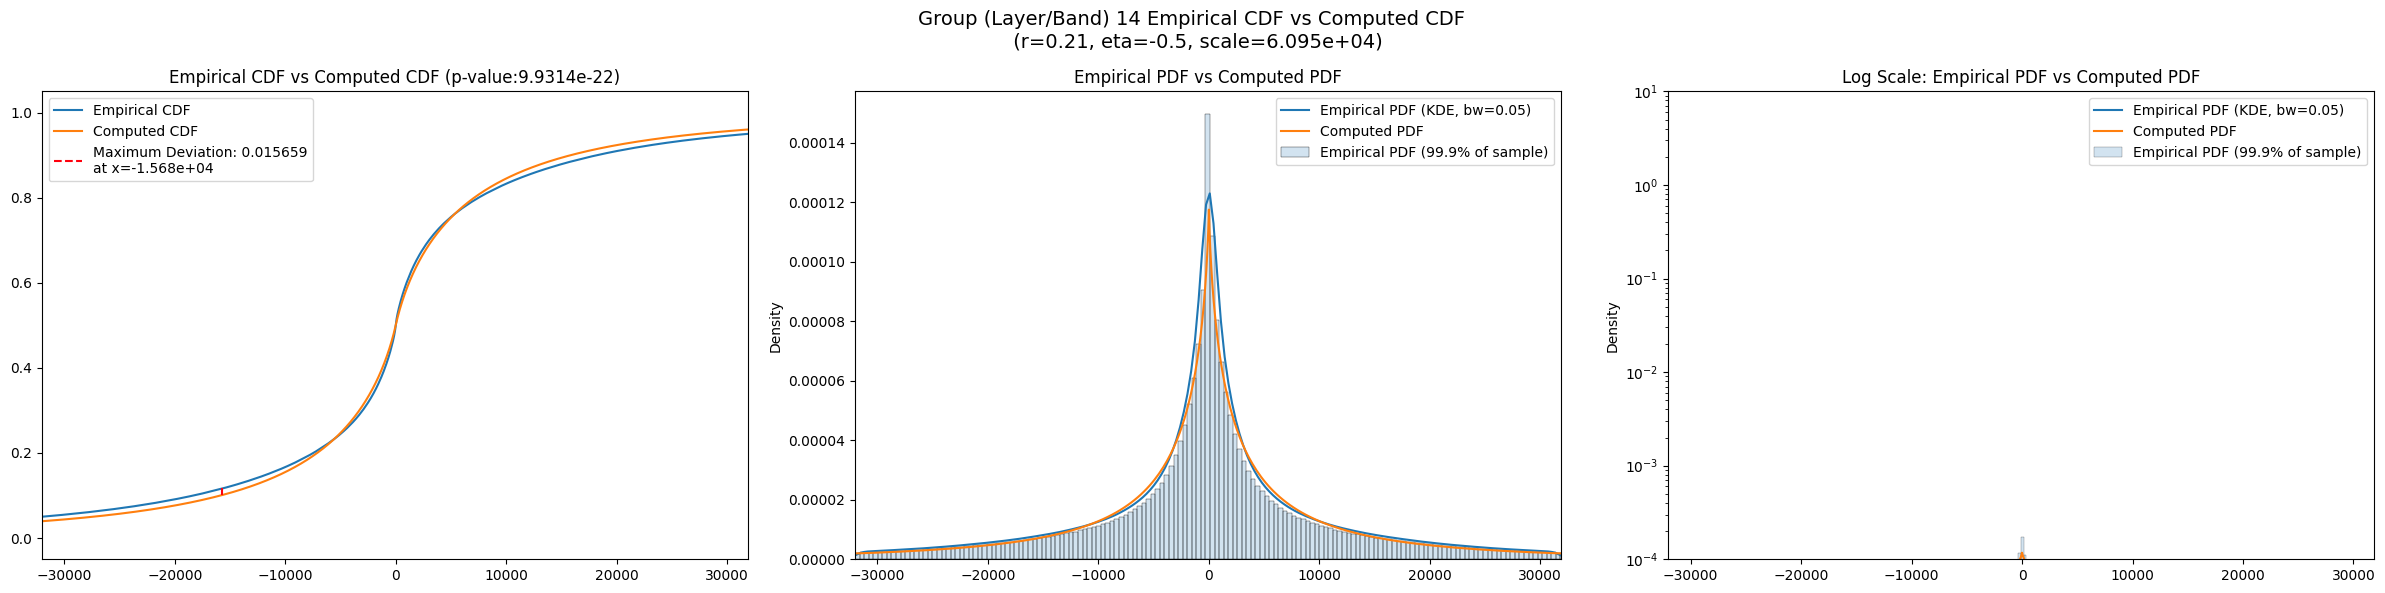

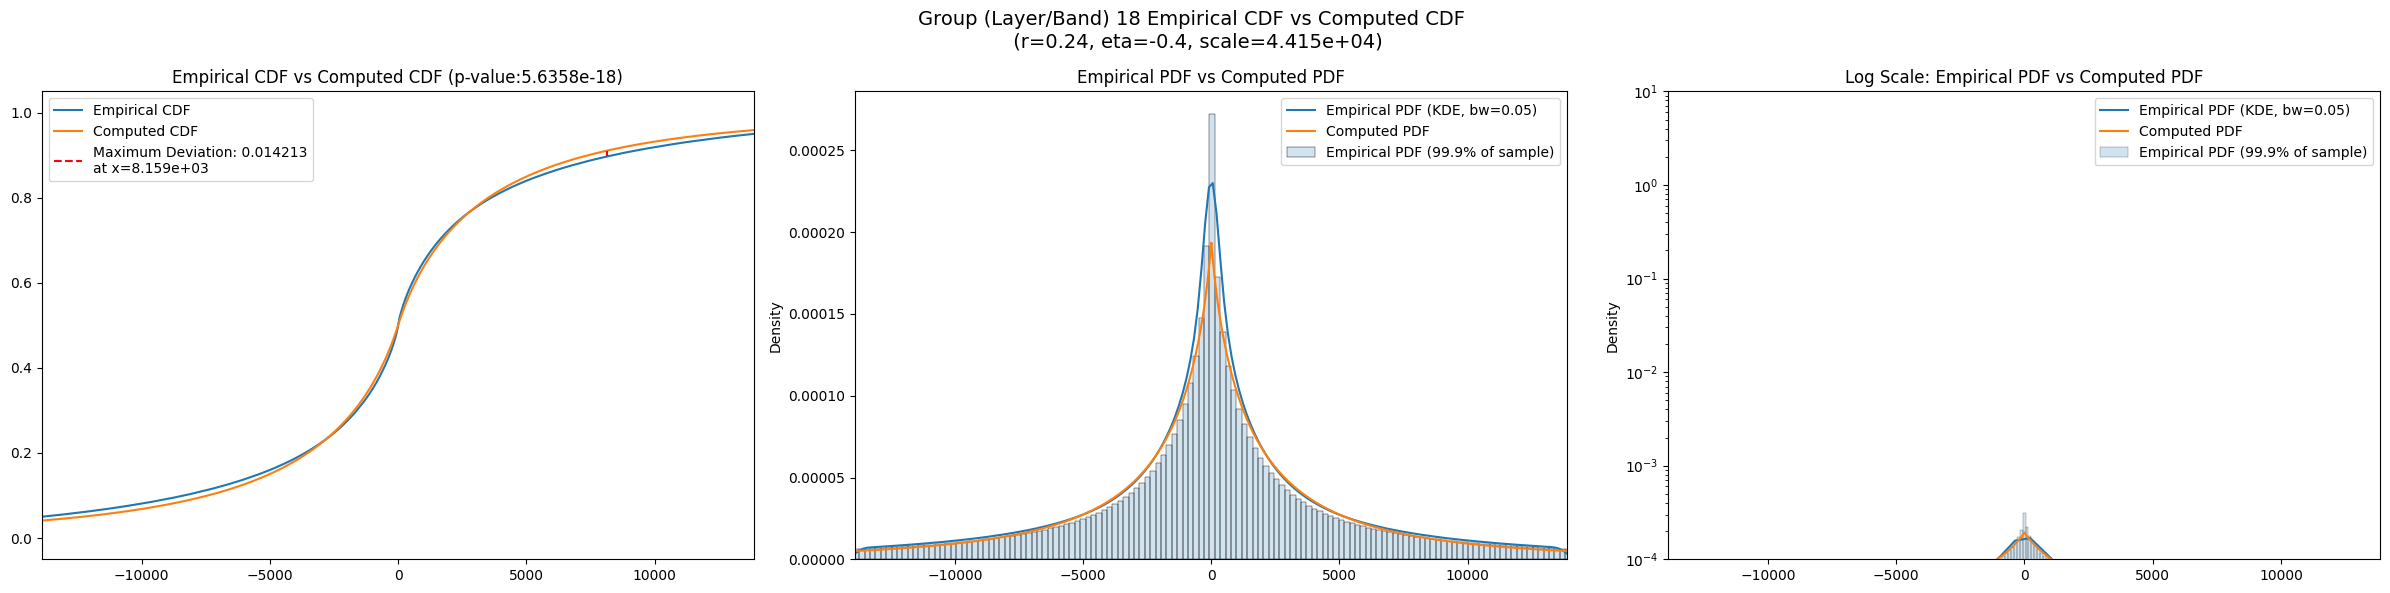

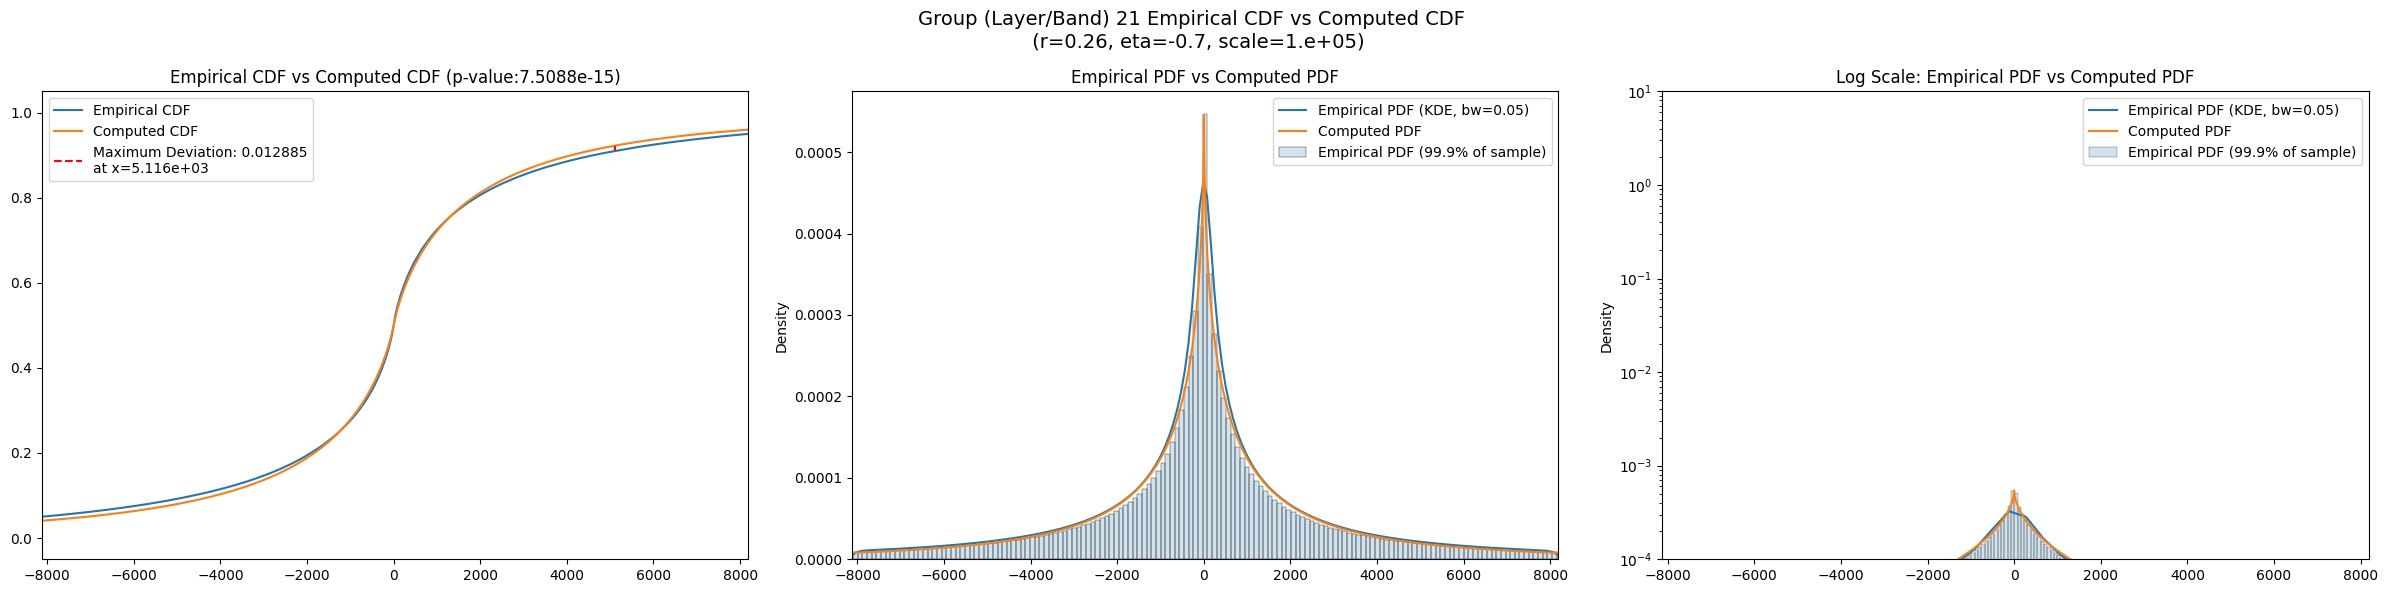

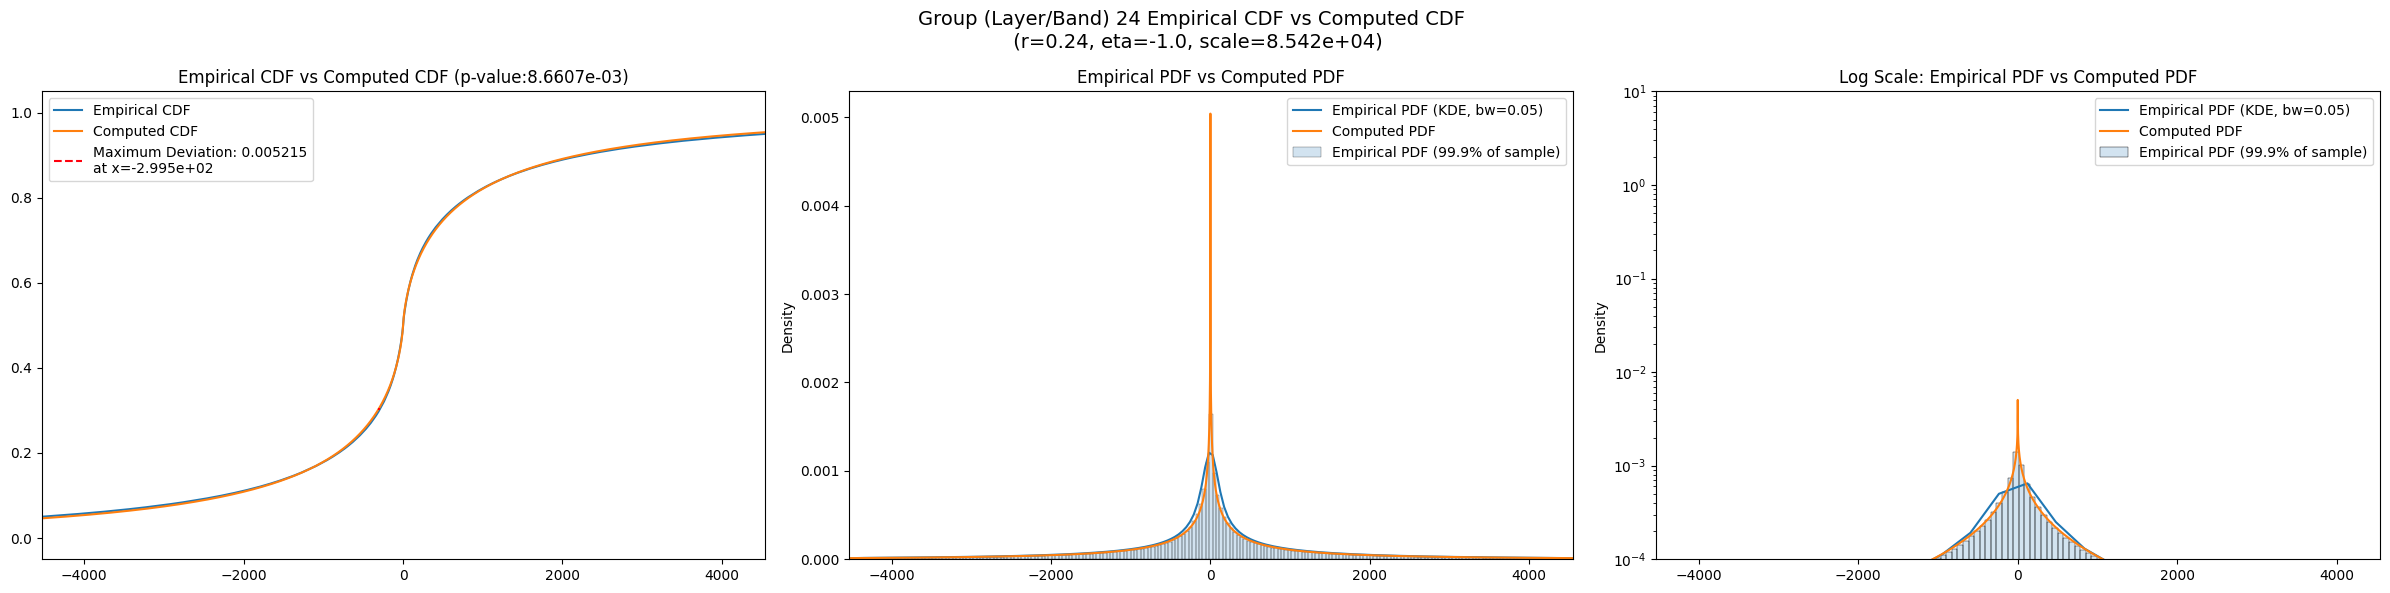

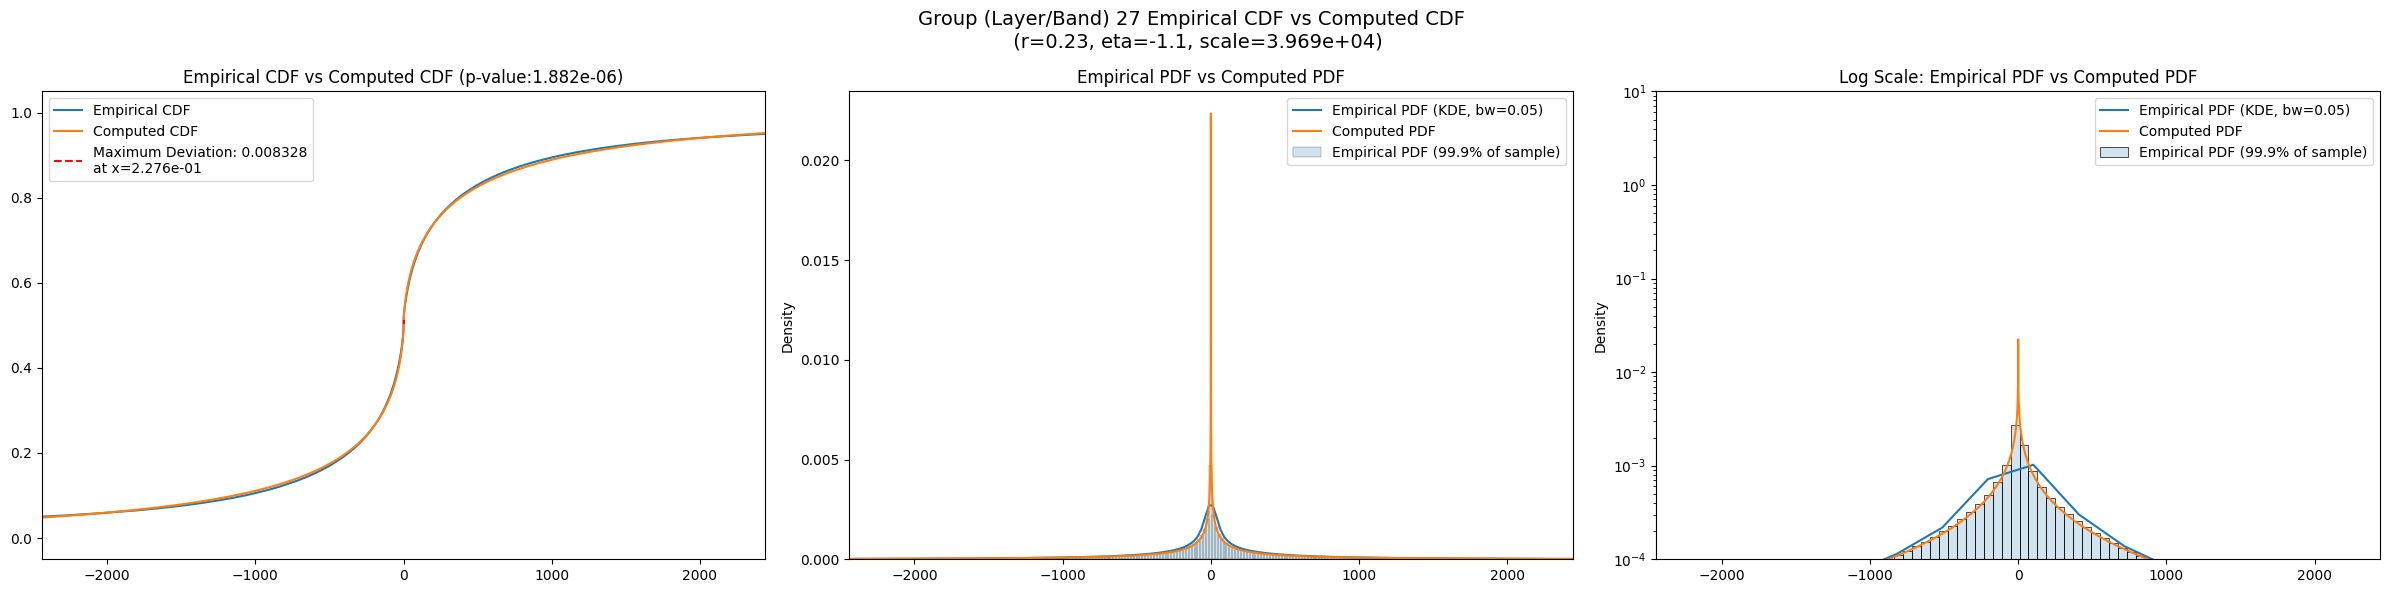

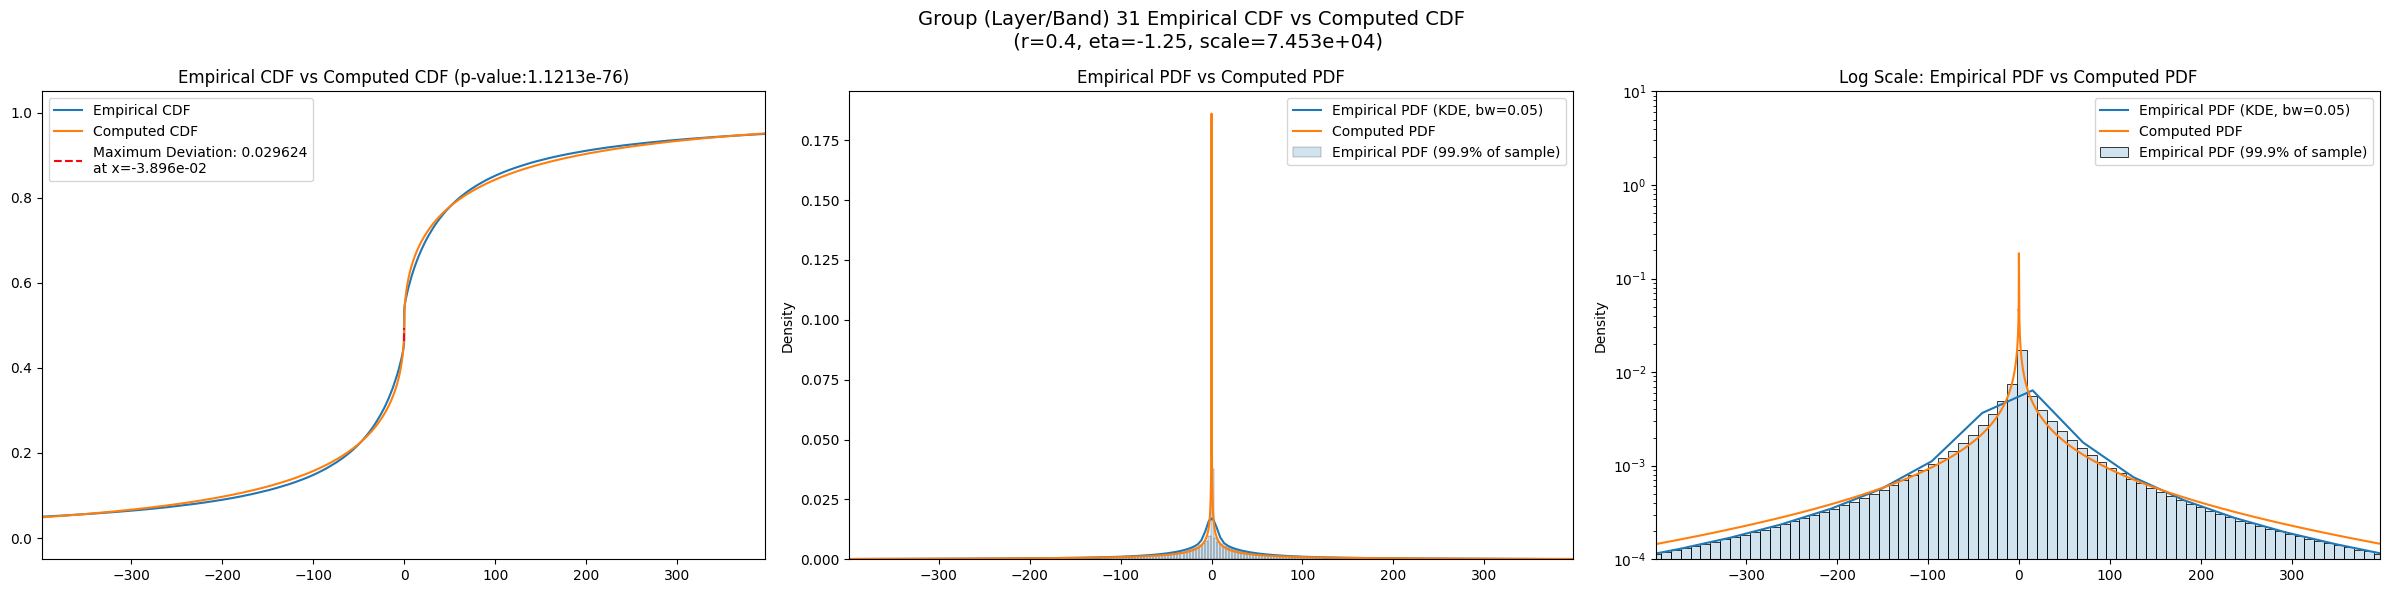

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
band                                                                    
2     5.139880e+07  4.463575e+07  6.101288e+07  34.220990   15.247752   
5     2.525491e+09  2.354647e+09  2.701157e+09   5.178192    4.624777   
8     1.756310e+09  1.640077e+09  1.875928e+09   4.848721    4.287468   
11    1.467358e+09  1.381364e+09  1.555059e+09   3.327720    2.993510   
14    4.540210e+08  4.182397e+08  4.909491e+08   7.741888    6.910471   
18    8.005176e+07  7.353718e+07  8.704562e+07   8.755204    6.906692   
21    2.976653e+07  2.698129e+07  3.283116e+07  12.357149    8.886501   
24    1.521077e+07  1.316765e+07  1.748722e+07  28.562206   21.736568   
27    1.005809e+07  8.507878e+06  1.174792e+07  37.199127   31.085604   
31    2.761875e+05  2.250151e+05  3.410578e+05  63.171585   39.072056   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2     119.304550       100000.0             0.003485        0.1          1.1   
5       5.771959       100000.0             0.042794        0.1          0.4   
8       5.422123       100000.0             0.023872        0.2          0.1   
11      3.676711       100000.0             0.025708        0.2          0.2   
14      8.619063       100000.0             0.017778        0.2         -0.4   
18     11.289118       100000.0             0.016854        0.2         -0.2   
21     18.062698       100000.0             0.014991        0.2         -0.4   
24     36.871605       100000.0             0.007207        0.2         -0.9   
27     44.256040       100000.0             0.010451        0.2         -1.0   
31    149.136670       100000.0             0.030875        0.3         -1.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...        3244.410              0.054799         1.889550e-261   
5     ...       19855.600              0.099328          0.000000e+00   
8     ...       24088.900              0.063959          0.000000e+00   
11    ...       22446.600              0.068108          0.000000e+00   
14    ...        9326.210              0.075699          0.000000e+00   
18    ...        4653.190              0.066425          0.000000e+00   
21    ...        2433.170              0.072751          0.000000e+00   
24    ...        1027.300              0.086770          0.000000e+00   
27    ...         471.050              0.089121          0.000000e+00   
31    ...          79.481              0.086346          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2         2859.3800             0.028472         7.348290e-71   2230.3500   
5        16892.1000             0.075162         0.000000e+00  13027.5000   
8        20551.1000             0.038949        3.014240e-132  16585.0000   
11       19332.1000             0.041751        6.705920e-152  15445.0000   
14        8058.5900             0.049559        6.801250e-214   6330.2800   
18        4026.4900             0.039924        6.273780e-139   3174.7300   
21        2108.5000             0.046917        1.007540e-191   1640.7400   
24         889.2570             0.062163         0.000000e+00    680.4580   
27         407.3070             0.065473         0.000000e+00    307.9690   
31          68.5995             0.063533         0.000000e+00     51.0967   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.028230   1.144350e-69          8.405699e-01  
5          0.076048   0.000000e+00         1.147364e-145  
8          0.043408  3.597130e-164          4.490667e-47  
11         0.044923  8.368420e-176          4.409924e-52  
14         0.0510

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003485                 0.004293          0.001950   
5                0.042794                 0.004293          0.040883   
8                0.023872                 0.004293          0.023172   
11               0.025708                 0.004293          0.024384   
14               0.017778                 0.004293          0.015659   
18               0.016854                 0.004293          0.014213   
21               0.014991                 0.004293          0.012885   
24               0.007207                 0.004293          0.005215   
27               0.010451                 0.004293          0.008362   
31               0.030875                 0.004293          0.025474   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.054799             0.028472       0.028230  
5                 0.099328             0.075162       0.076048  
8                 0.063959             0.038949       0.043408  
11                0.068108             0.041751       0.044923  
14                0.075699             0.049559       0.051074  
18                0.066425             0.039924       0.041847  
21                0.072751             0.046917       0.047731  
24                0.086770             0.062163       0.061891  
27                0.089121             0.065473       0.064814  
31                0.086346             0.063533       0.062909

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           5.139880e+07          0.001950    0.11      0.70       0.000015   
5           2.487539e+09          0.040883    0.12      0.10       0.150793   
8           1.756310e+09          0.023172    0.21      0.00   52300.417906   
11          1.467358e+09          0.024384    0.22      0.00   87747.619175   
14          4.540210e+08          0.015659    0.21     -0.50   60949.594133   
18          8.005176e+07          0.014213    0.24     -0.40   44150.799310   
21          2.976653e+07          0.012885    0.26     -0.70  100000.000000   
24          1.521077e+07          0.005215    0.24     -1.00   85420.705291   
27          6.031592e+06          0.008362    0.23     -1.10   39693.550623   
31          1.169665e+05          0.025474    0.40     -1.25   74528.783807   

      best_exclude_cutoff  
band                       
2                     0.0  
5                    25.0  
8                     0.0  
11                    0.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                    0.0  
27                  300.0  
31                  475.0